In [1]:
%load_ext autoreload
%autoreload 2
from Network import Network
from FrankWolf import *
from EntropyMaximisation import *
from RemoveBraess import *

import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from graph_tool.centrality import betweenness

from IPython.display import display_markdown

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


# Identification of Braess links in traffic Networks - Finding braess links

In this notebook, we reuse the previous results to finally test our hypothese :

$$
x_{ij}^{UE,\ od} > 0 \textrm{ and } x_{ij}^{SO,\ od} = 0 \Rightarrow \textrm{Link (i, j) is a Braess link for OD (o, d)}
$$

Where :
- $x_{ij}^{UE/SO,\ od}$ represent the flow on the link from node $i$ to node $j$, that is caused by the trafic going from origin $o$ to destination $d$, at User Equilibrium, respectively at System Optimum

In [2]:
net = Network("SiouxFalls")
UE_OD_flows = net.load_flow("UE_OD_flows")
SO_OD_flows = net.load_flow("SO_OD_flows")

Text(0.5, 0, 'OD link flow values (log scale)')

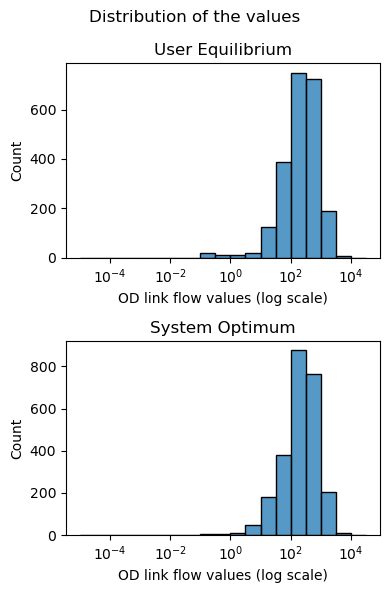

In [4]:
# Visualisation
fig, axes = plt.subplots(2, 1, layout = "tight", figsize=(4, 6))
sns.histplot(x=UE_OD_flows[(UE_OD_flows>0)], bins=np.arange(-5, 5, 0.5), log_scale=True, ax=axes[0])
plt.suptitle("Distribution of the values")
axes[0].set_title("User Equilibrium")
axes[0].set_xlabel("OD link flow values (log scale)")
sns.histplot(x=SO_OD_flows[(SO_OD_flows>0)], bins=np.arange(-5, 5, 0.5), log_scale=True, ax=axes[1])
axes[1].set_title("System Optimum")
axes[1].set_xlabel("OD link flow values (log scale)")

## A note on threshold

Previously, we applied thresholds to remove near-zero values and consider as null. Here, we will not apply here such a threshold at first, firstly because, as a result from the previous thresholds, OD-based flows have a value of at least 0.1, but also because we will later on consider the magnitude of the UE OD-based flow as a potential explaining variable, which if it shows a different component for the smaller values would indicates that applying a threshold would be usefull.

## Selecting suspicious links

In [3]:
mask = (UE_OD_flows > 0) & (SO_OD_flows == 0)
print(f"Total number of links identified : {mask.sum()}")
print(f"ODs concerned : {(mask.sum(axis=2)>0).sum()} / {(net.trips>0).sum()}")


Total number of links identified : 260
ODs concerned : 68 / 528


### Analyse the ODs concerned :

Let's have a look at which ODs appear most in our mask

In [14]:
# Analyse OD concerned :
links_per_OD = pd.DataFrame(mask.sum(axis=2))
links_per_OD.index += 1
links_per_OD.columns += 1
links_per_OD.index.name = "Origin"
links_per_OD.columns.name = "Destination"
s = links_per_OD.style \
            .set_caption("Number of links concerned, per OD") \
            .background_gradient(axis=None) \
            .map(lambda x: 'opacity: 20%;' if x==0 else '')

# print(s.to_latex(convert_css=True))
s

#### Analyse OD 13 - 19 (one of the OD that has the most identified links)

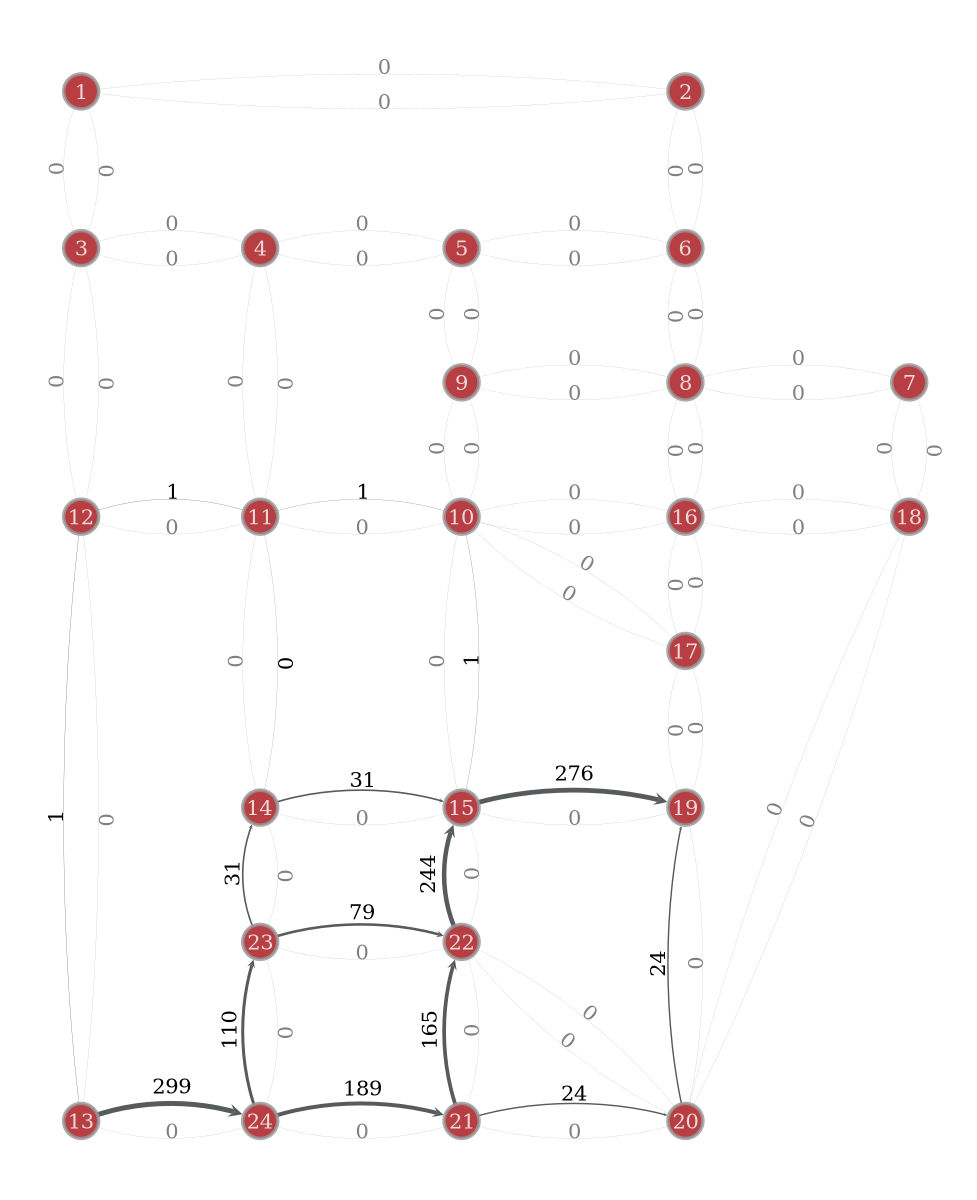

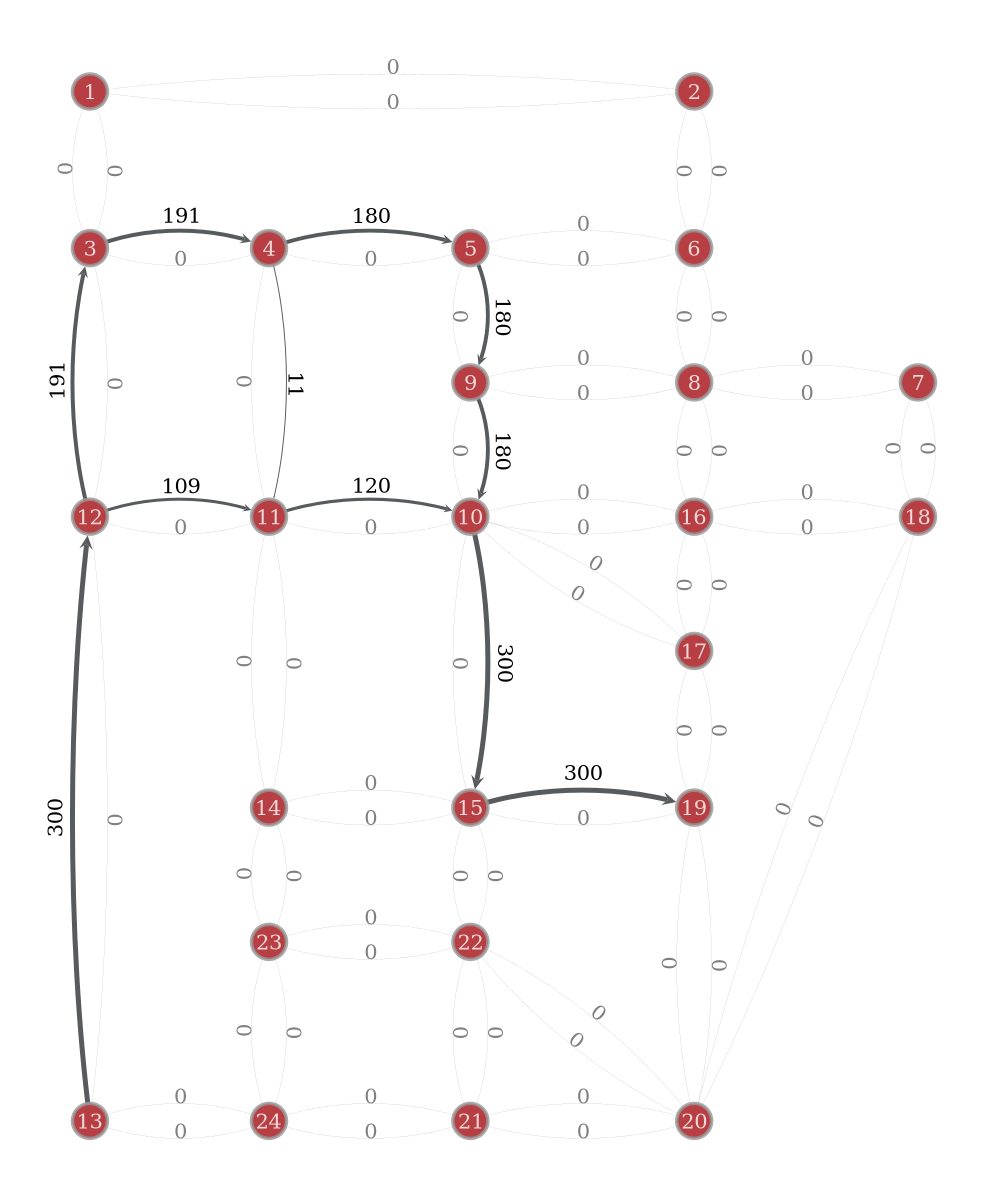

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd5ebb44ec0, at 0x7fd5cbb45cd0>

In [17]:
net.draw(flows_by_OD = UE_OD_flows, o = 13, d = 19, output="figs/UE_flows_13_19.pdf")
net.draw(flows_by_OD = UE_OD_flows, o = 13, d = 19)

net.draw(flows_by_OD = SO_OD_flows, o = 13, d = 19, output="figs/SO_flows_13_19.pdf")
net.draw(flows_by_OD = SO_OD_flows, o = 13, d = 19)

#### Ban the links concerned for each OD

In [ ]:
# For each OD (where > 0), ban all concerned links to see the impact on the total travel time
try_removing_braess(net, mask, save_folder="files/masked/no_threshold", export_folder="exports/masked/no_threshold")

### Analyse the most common links

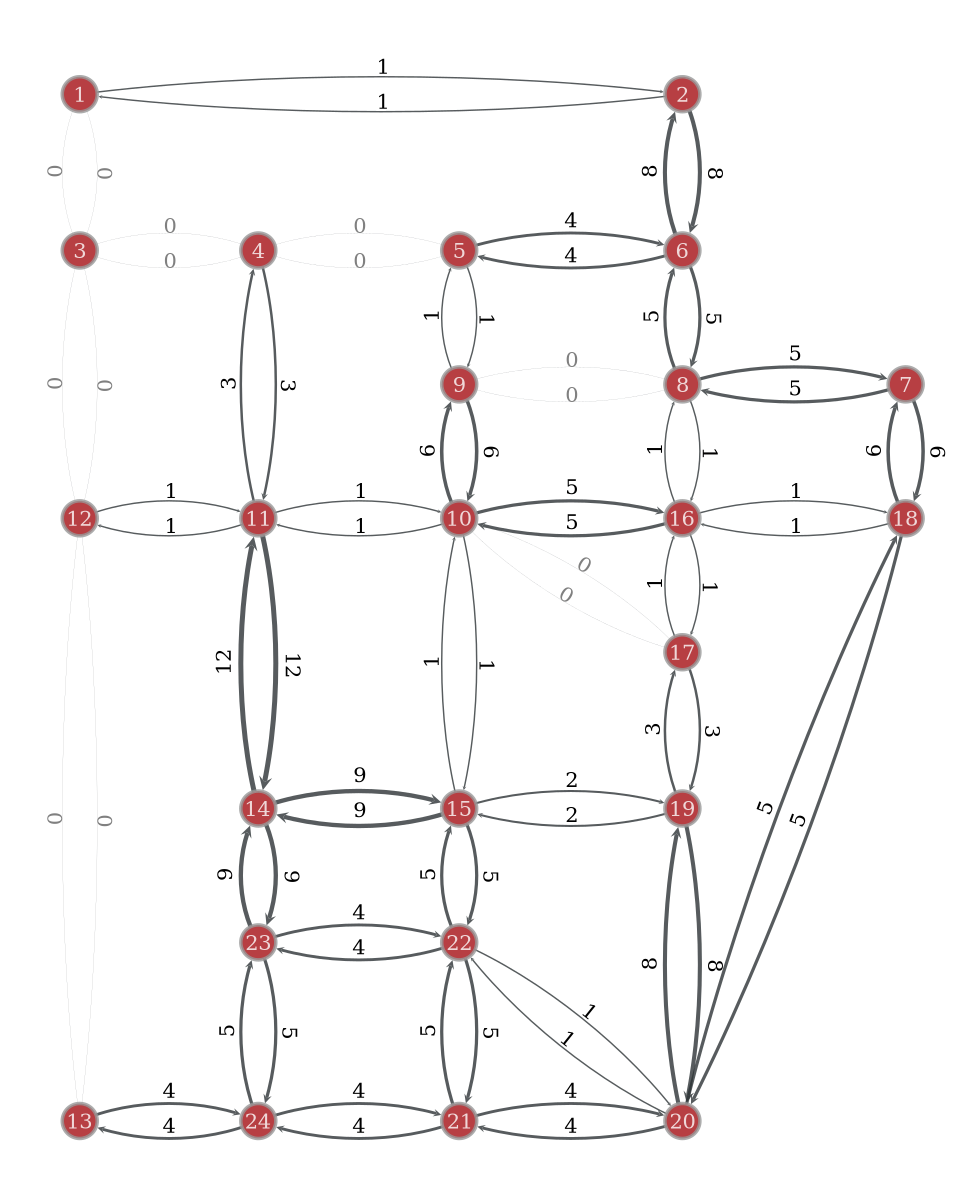

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd5ebb44ec0, at 0x7fd5cbb7f980>

In [15]:
# Analyse links concerned (most common links):
OD_per_links = pd.DataFrame(mask.sum(axis=0).sum(axis=0), columns=["Number of ODs"]).T

OD_per_links.columns += 1
OD_per_links.columns.name = "Link number"

s= OD_per_links.style \
            .set_caption("Number of OD concerned, per link") \
            .background_gradient(axis=None) \
            .map(lambda x: 'opacity: 20%;' if x==0 else '')

display(s)

s = OD_per_links.sort_values("Number of ODs", axis = 1, ascending=False) \
            .style \
            .set_caption("Number of OD concerned, per link, sorted") \
            .background_gradient(axis=None) \
            .map(lambda x: 'opacity: 20%;' if x==0 else '')
display(s)

net.draw(False, net.new_edge_property("float", OD_per_links.loc["Number of ODs"]), output = "figs/links_n_id.pdf")
net.draw(False, net.new_edge_property("float", OD_per_links.loc["Number of ODs"]))

#### Analyse link 34 (one of the most common link)

In [18]:
# Let's have a look at link 34 (one of the two that appears most often) : from node 11 to node 14
print("ODs that have flow passing through link 34 at UE but not at SO :")
print(", ".join([f"{o+1:2d}->{d+1:2d}" for o, d in zip(*np.nonzero(mask[:, :, 33]))]))

print("ODs that have flow passing through link 34 at UE but also at SO :")
print(", ".join([f"{o+1:2d}->{d+1:2d}" for o, d in zip(*np.nonzero(~mask[:,:,33] & (UE_OD_flows[:, :, 33] > 0)))]))

ODs that have flow passing through link 34 at UE but not at SO :
 4->23,  5->23,  6->23, 11->15, 11->19, 11->20, 11->21, 11->22, 12->15, 12->19, 13->15, 13->19
ODs that have flow passing through link 34 at UE but also at SO :
 1->14,  2->14,  3->14,  4->14,  5->14,  6->14,  9->14,  9->23, 10->14, 10->23, 10->24, 11->14, 11->23, 11->24, 12->14, 13->14


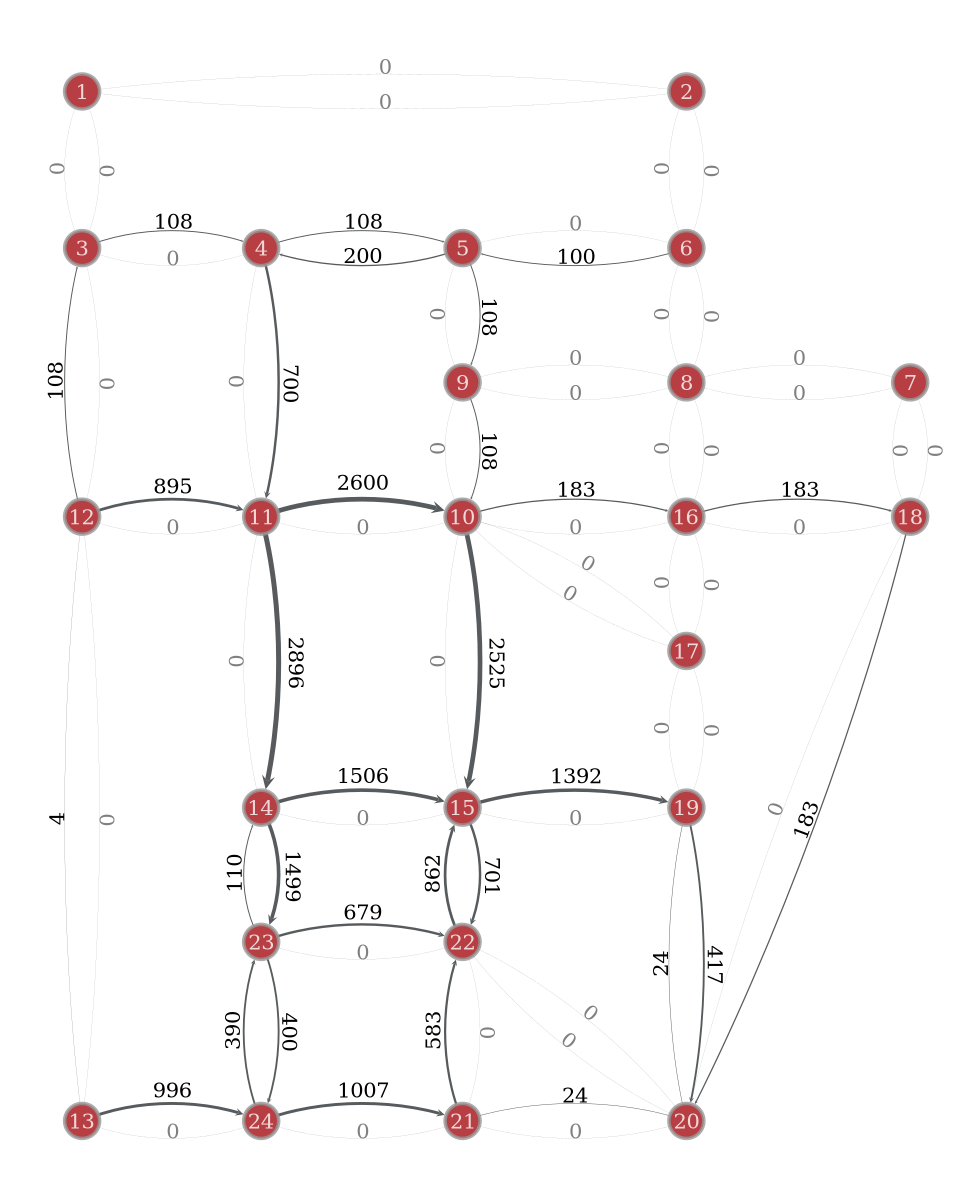

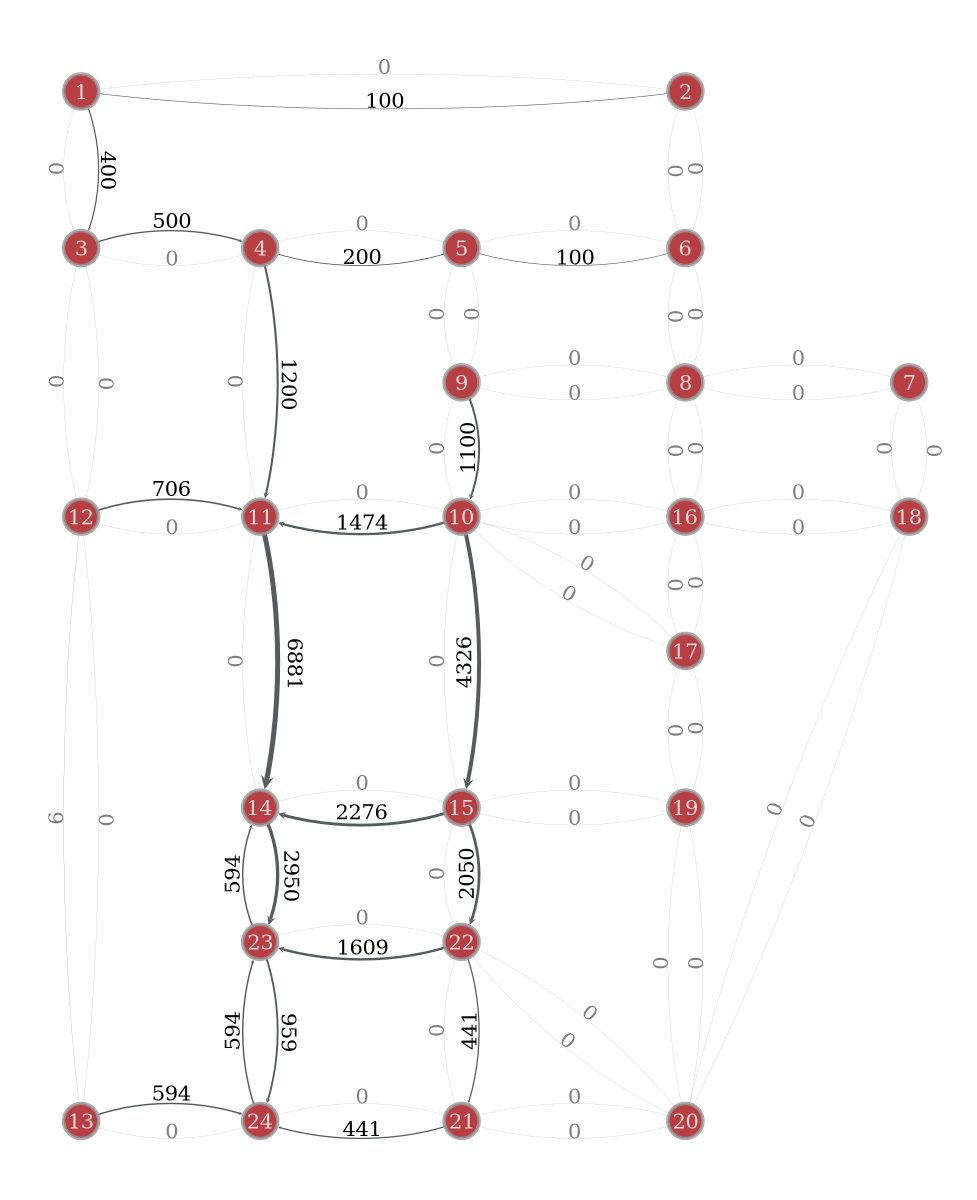

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3b3af09760, at 0x7f3a8cdbcef0>

In [24]:
flow_masked_link_34 = UE_OD_flows[*np.nonzero(mask[:, :, 33])].sum(axis=0)
net.draw(flows=net.new_edge_property("float", vals=flow_masked_link_34))

flow_not_masked_link_34 = UE_OD_flows[*np.nonzero(~mask[:,:,33] & (UE_OD_flows[:, :, 33] > 0))].sum(axis=0)
net.draw(flows=net.new_edge_property("float", vals=flow_not_masked_link_34))

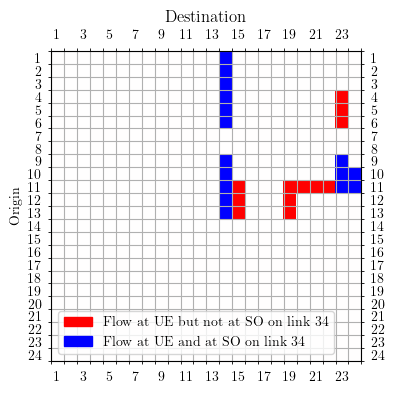

In [92]:
matrix = np.zeros(mask.shape[:2])
matrix[mask[:, :, 33]] = 1
matrix[(~mask[:,:,33]) & (UE_OD_flows[:, :, 33] > 0)] = -1

im = plt.matshow(matrix, cmap="bwr", extent = [0.5, 24.5, 24.5, 0.5])
# Legend
get_c = lambda x: im.cmap(im.norm(x))
patches = [ mpatches.Patch(color=get_c(1), label="Flow at UE but not at SO on link 34"), mpatches.Patch(color=get_c(-1), label="Flow at UE and at SO on link 34")]
plt.legend(handles=patches, loc="lower left")

plt.xticks(np.arange(0.5, 25), minor=True)
plt.yticks(np.arange(0.5, 25), minor=True)
plt.yticks(np.arange(1, 25))
plt.xticks(np.arange(1, 25, 2))
plt.grid(which="minor")
plt.ylabel("Origin")
plt.title("Destination")
plt.gcf().set_size_inches(4, 4)

im.axes.tick_params(left = False, top = False, bottom=False, labelright=True, labelbottom = True, which="major")
im.axes.tick_params(right = True, bottom=True, which="minor")

plt.savefig("figs/OD_pair_14.pgf", bbox_inches="tight")

#### Ban most concerned links from the network (for all OD)

In [ ]:
# For each concerned link, ban it from the network (so for all OD)
links = OD_per_links[OD_per_links>0].dropna(axis=1).columns
remove_all_OD(net, links, save_folder="files/masked/no_threshold", export_folder="export/masked/no_threshold")

## Analyse the relationship between link and OD

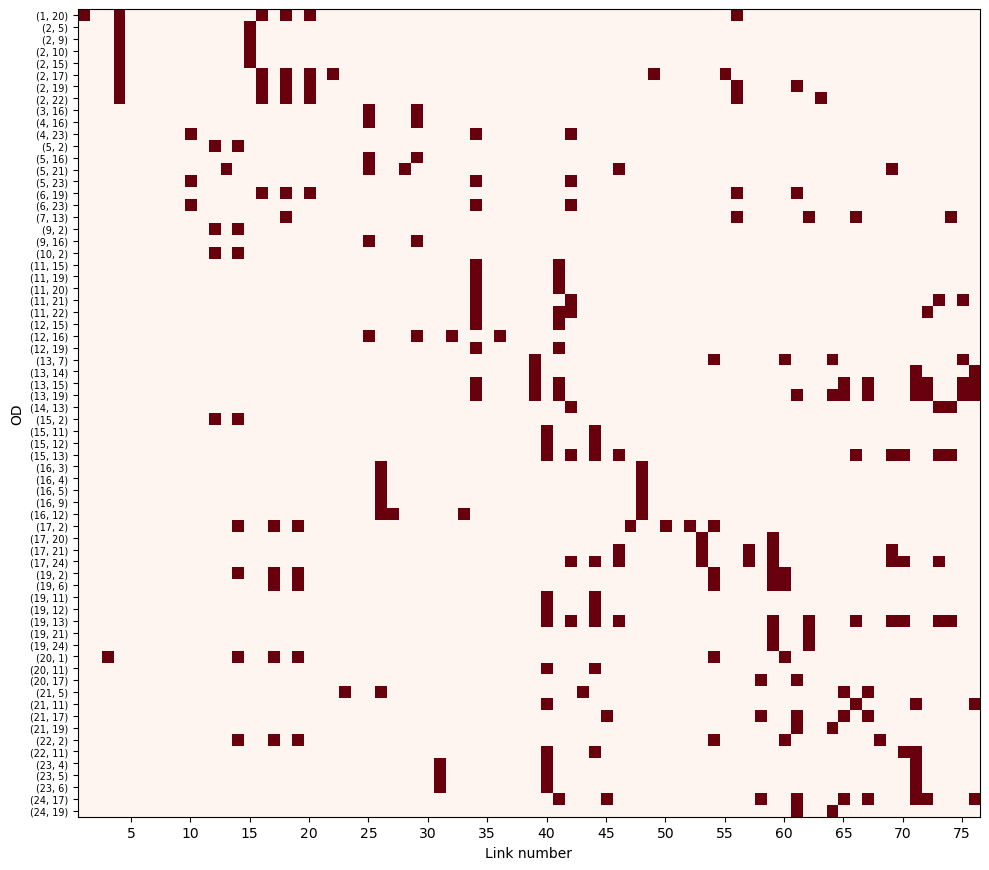

In [85]:
# See which link is concerned for which OD :
plt.figure(figsize=(10,10))
im = plt.imshow(mask[*np.nonzero(mask.sum(axis=2))], cmap="Reds")
plt.xticks(np.arange(4, mask.shape[-1], 5), np.arange(4, mask.shape[-1], 5)+1)
plt.yticks(np.arange((mask.sum(axis=2)>0).sum()), list(zip(*[i+1 for i in np.nonzero(mask.sum(axis=2))])), size="x-small")
im.axes.set_xlabel("Link number")
im.axes.set_ylabel("OD")
#plt.ylabel("(o, d)")
plt.tight_layout()
plt.show()

Text(966.1527777777777, 0.5, 'OD')

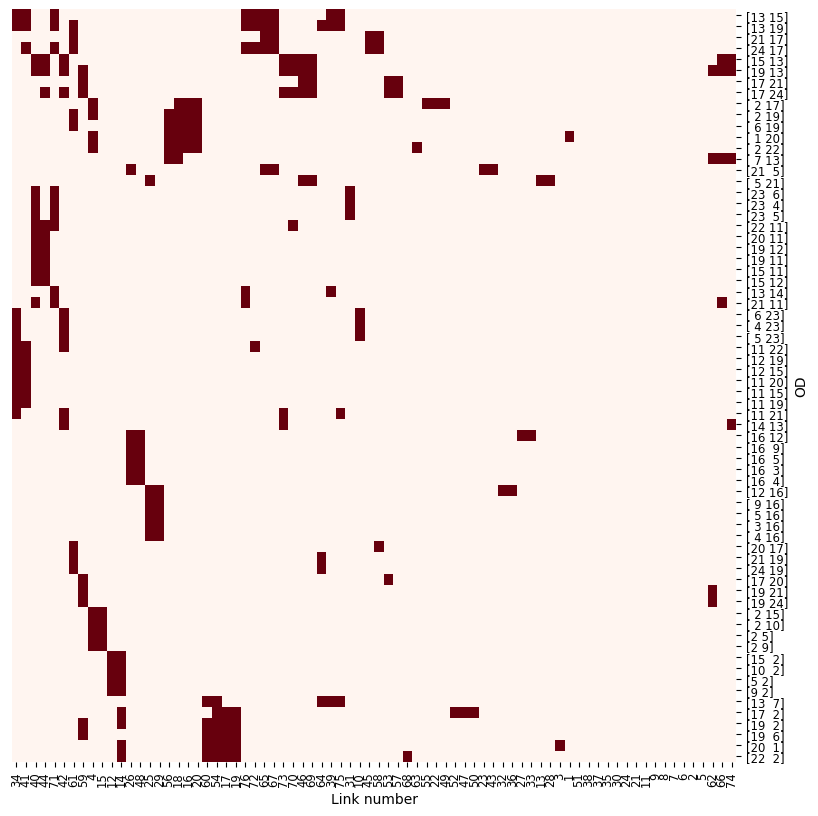

In [77]:
# See which link is concerned for which OD :
cg = sns.clustermap(mask[*np.nonzero(mask.sum(axis=2))], cmap="Reds", cbar=False, yticklabels=list(zip(*[i+1 for i in np.nonzero(mask.sum(axis=2))])), xticklabels = np.arange(mask.shape[-1])+1)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_cbar.set_visible(False)
cg.ax_heatmap.tick_params(labelsize="small")
cg.ax_heatmap.set_xlabel("Link number")
cg.ax_heatmap.set_ylabel("OD")
#plt.yticks(np.arange(0.5, (mask.sum(axis=2)>0).sum()), zip(*np.nonzero(mask.sum(axis=2))), size="x-small", rotation=0)
#plt.ylabel("(o, d)")
#plt.tight_layout()
#plt.show()

## Test the hypothese

In order to test the hypothesis, we will compare the total travel time after banning the links concerned for the ODs concerned. We will also take a look at potential explanatory variables

### After banning, for each OD, all concerned links

We will explore the following explanatory variables that could explain the difference in improvement for each OD :
- Demand for that OD
- Number of removed links (= # of identified link for that OD)
- Flow at UE for the given OD on the links (min, mean, max)
- Percentage of the OD UE paths impacted by the ban
- Percentage of the OD demand impacted by the ban (using the paths)
- Betweeness centrality of the links [min, mean, max]
- Total flow on the links impacted (all OD), (min, mean, max)

This set of variables explore both the importance of the identified links for the given OD and in the general network, as well as the importance of the OD to the network. However, this only include a few topological measures (betweeness centrality, the total flow could be considered one as well) but further research into centrality measures and their potential as explanatory variables is probably needed.

In [63]:
# Get the paths
# UE  
flows_by_o = net.load_flow("UE_flows_by_o_filtered")

_, paths = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o, flow_limit = 0.1, return_paths=True)

/home/ars/Braess-Links-Identification/EntropyMaximisation.py:163: RuntimeWarning: invalid value encountered in divide
  psi_r_ij[:, in_edge_indices] = np.where(eta_rj[:,[j]] > 0, x_a[:, in_edge_indices]/eta_rj[:,[j]], 0)
100%|██████████| 24/24 [01:08<00:00,  2.84s/it]


In [65]:
# To compare, compute total travel time without banning links.
flows = net.load_flow(f"fw_p4", folder="files/precision", dim=1)
original_ttt = float(compute_total_travel_time(net, flows))
print("original total travel time :", original_ttt)

# Compute the betweeness centrality
_, edge_betweenness = betweenness(net, )

records = {}
for o, d in tqdm(list(zip(*np.where(mask.sum(axis=2)>0)))):
    flows = net.load_flow(f"o{o}d{d}", dim=1, folder="files/masked/no_threshold")
    ttt = float(compute_total_travel_time(net, flows))

    # Get the impact on the paths
    od_paths = paths[o,d]
    impacted_paths = 0
    impacted_flow = 0.0
    for path, path_flow in od_paths:
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        if (net.get_edge_mask(path_edges) * mask[o, d]).sum() > 0:
            impacted_paths +=1
            impacted_flow += path_flow
    
    records[o+1,d+1] = {
        "Banned links": ", ".join((np.nonzero(mask[o,d])[0]+1).astype(str)),
        "Total travel time": ttt,
        "Improvement": original_ttt - ttt,
        "Relative improvement": (original_ttt - ttt) / original_ttt,
        "Has improved" : (original_ttt - ttt) > 0,
        "OD_demand" : net.trips[o,d],
        "Improvement normalised": float(original_ttt - ttt)/net.trips[o,d],
        "N removed links": mask[o,d].sum(),
        "UE_flows_on_banned_links": UE_OD_flows[o,d,mask[o,d]],
        "min_UE_flow_on_banned_links" : UE_OD_flows[o,d,mask[o,d]].min(),
        "mean_UE_flow_on_banned_links" : UE_OD_flows[o,d,mask[o,d]].mean(),
        "max_UE_flow_on_banned_links" : UE_OD_flows[o,d,mask[o,d]].max(),
        "percentage_OD_paths_impacted": impacted_paths / len(od_paths),
        "percentage_OD_demand_impacted" : impacted_flow / net.trips[o, d],
        "betweenness_centrality" : edge_betweenness.a[mask[o, d]],
        "min_betweenness_centrality" : float(edge_betweenness.a[mask[o, d]].min()),
        "mean_betweenness_centrality" : float(edge_betweenness.a[mask[o, d]].mean()),
        "max_betweenness_centrality" : float(edge_betweenness.a[mask[o, d]].max()),
        "total_flows_on_banned_links": flows.a[mask[o,d]],
        "min_total_flow_on_banned_links" : float(flows.a[mask[o,d]].min()),
        "mean_total_flow_on_banned_links" : float(flows.a[mask[o,d]].mean()),
        "max_total_flow_on_banned_links" : float(flows.a[mask[o,d]].max()),
    }
df = pd.DataFrame.from_dict(records, orient="index")
df.index.set_names(["o", "d"], inplace=True)
df

original total travel time : 7479625.830083258


  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [00:00<00:00, 608.26it/s]


Banned links  Total travel time  Improvement  \
o  d                                                                        
1  20                1, 4, 16, 18, 20, 56       7.480691e+06 -1065.345130   
2  5                                4, 15       7.479804e+06  -178.651005   
   9                                4, 15       7.479692e+06   -66.199526   
   10                               4, 15       7.474682e+06  4943.715854   
   15                               4, 15       7.479504e+06   122.027883   
...                                   ...                ...          ...   
23 4                           31, 40, 71       7.474923e+06  4702.776264   
   5                           31, 40, 71       7.478584e+06  1041.678513   
   6                           31, 40, 71       7.478752e+06   873.477596   
24 17  41, 45, 58, 61, 65, 67, 71, 72, 76       7.479785e+06  -158.750871   
   19                              61, 64       7.479588e+06    38.187464   

       Relative improvement  Has improved  OD_demand  Improvement normalised  \
o  d                                                                           
1  20             -0.000142         False      300.0               -3.551150   
2  5              -0.000024         False      100.0               -1.786510   
   9              -0.000009         False      200.0               -0.330998   
   10              0.000661          True      600.0                8.239526   
   15              0.000016          True      100.0                1.220279   
...                     ...           ...        ...                     ...   
23 4               0.000629          True      500.0                9.405553   
   5               0.000139          True      100.0               10.416785   
   6               0.000117          True      100.0                8.734776   
24 17             -0.000021         False      300.0               -0.529170   
   19              0.000005          True      100.0                0.381875   

       N removed links                           UE_flows_on_banned_links  \
o  d                                                                        
1  20                6         [300.0, 300.0, 300.0, 300.0, 300.0, 300.0]   
2  5                 2             [83.54049139424346, 83.54049139424346]   
   9                 2           [167.08098278848692, 167.08098278848692]   
   10                2             [501.2429483654608, 501.2429483654608]   
   15                2             [83.53951641777103, 83.53951641777103]   
...                ...                                                ...   
23 4                 3  [499.97890760522034, 499.97890760522034, 499.9...   
   5                 3  [99.99578152104407, 99.99578152104407, 99.9957...   
   6                 3  [99.99460756953412, 99.99460756953412, 99.9946...   
24 17                9  [17.003299676926844, 150.15725075783524, 163.4...   
   19                2             [8.141796408282557, 8.141796408282557]   

       min_UE_flow_on_banned_links  ...  percentage_OD_paths_impacted  \
o  d                                ...                                 
1  20                   300.000000  ...                          1.00   
2  5                     83.540491  ...                          0.50   
   9                    167.080983  ...                          0.50   
   10                   501.242948  ...                          0.50   
   15                    83.539516  ...                          0.50   
...                            ...  ...                           ...   
23 4                    499.978908  ...                          1.00   
   5                     99.995782  ...                          1.00   
   6                     99.994608  ...                          1.00   
24 17                    13.309100  ...                          0.80   
   19                     8.141796  ...                          0.25   

       percentage_OD_demand_impact

In [6]:
# For comparison, we compute the travel time of frankwolf with precision 10^-6, to see if the precision has an impact on the travel time
flows_p6 = net.load_flow(f"fw_p6", folder="files/precision", dim=1)
ttt_p6 = float(compute_total_travel_time(net, flows_p6))
print("Difference in travel time between precision 1e-4 and 1e-6 : ", ttt_p6 - original_ttt, f"({(ttt_p6 - original_ttt)/original_ttt*100:.3f} % of the original travel time)")
proportion_in_this_scale = (df["Improvement"] < (ttt_p6 - original_ttt)).mean()

print(f"Percentage of results negative : \t{100*(df["Improvement"] < (0)).mean():.1f} %")
print(f"Percentage of results lower than the difference in travel time: \t{100*proportion_in_this_scale:.1f} %")


Difference in travel time between precision 1e-4 and 1e-6 :  593.7807534653693 (0.008 % of the original travel time)
Percentage of results negative : 	42.6 %
Percentage of results lower than the difference in travel time: 	58.8 %


We see that 16.2 % of the results did improve, but by less than the absolute difference in travel time from an increased precision.

#### Initial analysis

Before looking at explanatory variable, let's start with visualising the results themselves

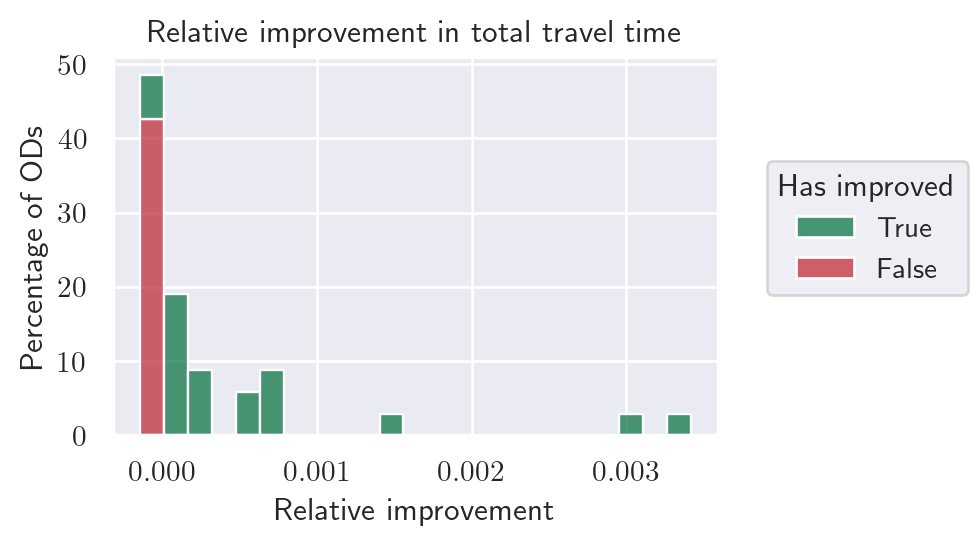

In [72]:
(
    so.Plot(data=df, color="Has improved", x="Relative improvement")
    .add(so.Bars(), so.Hist("percent"), so.Stack())
    .scale(color="blend:#006f3c,#bf212f")
    .label(y="Percentage of ODs", title="Relative improvement in total travel time")
    .layout(size=(4, 3))
    .plot()
    .save("figs/results/hist.pgf", bbox_inches="tight")
)

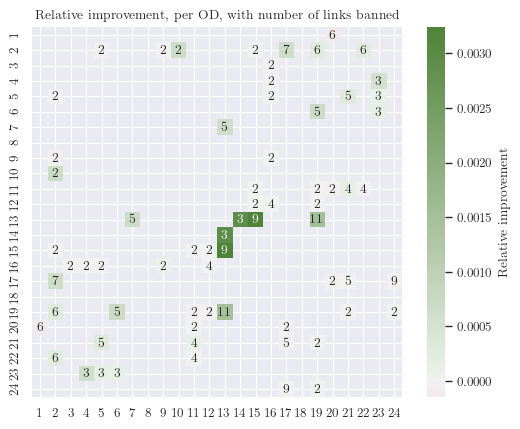

In [32]:
matrix = df.reset_index().pivot(index="o", columns="d", values="Relative improvement")
matrix = matrix.reindex(pd.RangeIndex(1,25))
matrix = matrix.reindex(pd.RangeIndex(1,25), axis=1)

matrix = matrix.to_numpy()
im = sns.heatmap(matrix,
                annot = mask.sum(axis=2),
                cmap=sns.diverging_palette(0, 120, as_cmap=True),
                cbar_kws=dict(label = "Relative improvement"),
                vmin = np.nanmin(matrix),
                center=0,
                robust=True,
                square=True,
                xticklabels = np.arange(1,25),
                yticklabels= np.arange(1,25))

plt.title("Relative improvement, per OD, with number of links banned")
plt.savefig("figs/results/OD_comparison_results.pgf", bbox_inches="tight")

#### OD demand

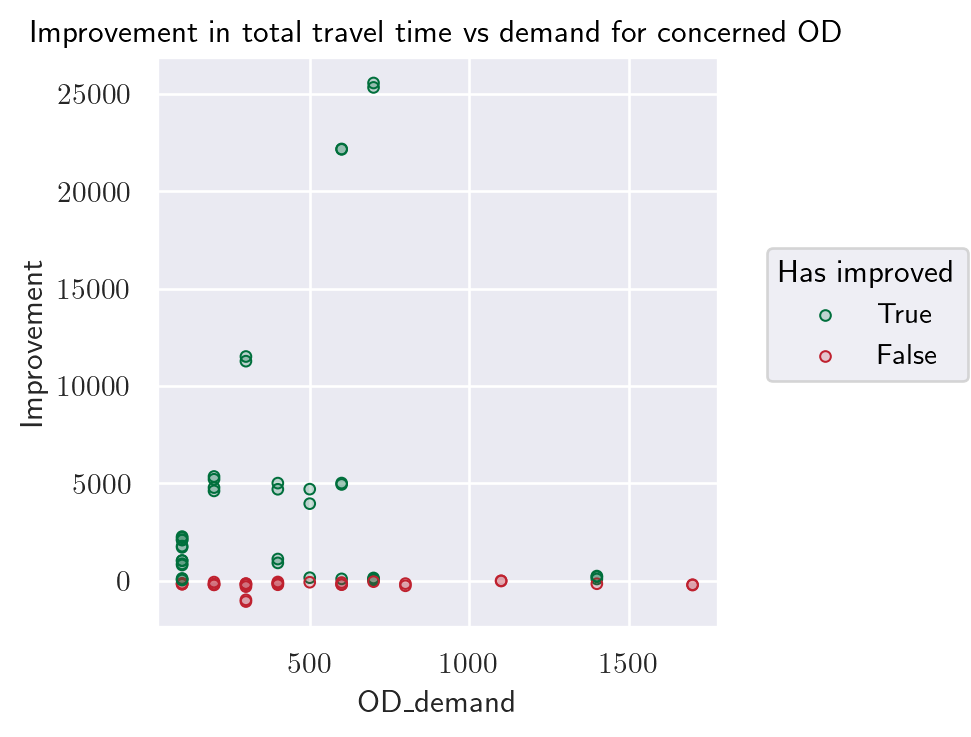

In [ ]:
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Improvement")
    .add(so.Dots())
    .scale(color="blend:#006f3c,#bf212f")
    .label(title="Improvement in total travel time vs demand for concerned OD")
    .layout(size=(4, 4))
    .plot()
    .save("figs/results/OD_demand.pgf", bbox_inches = "tight")
)

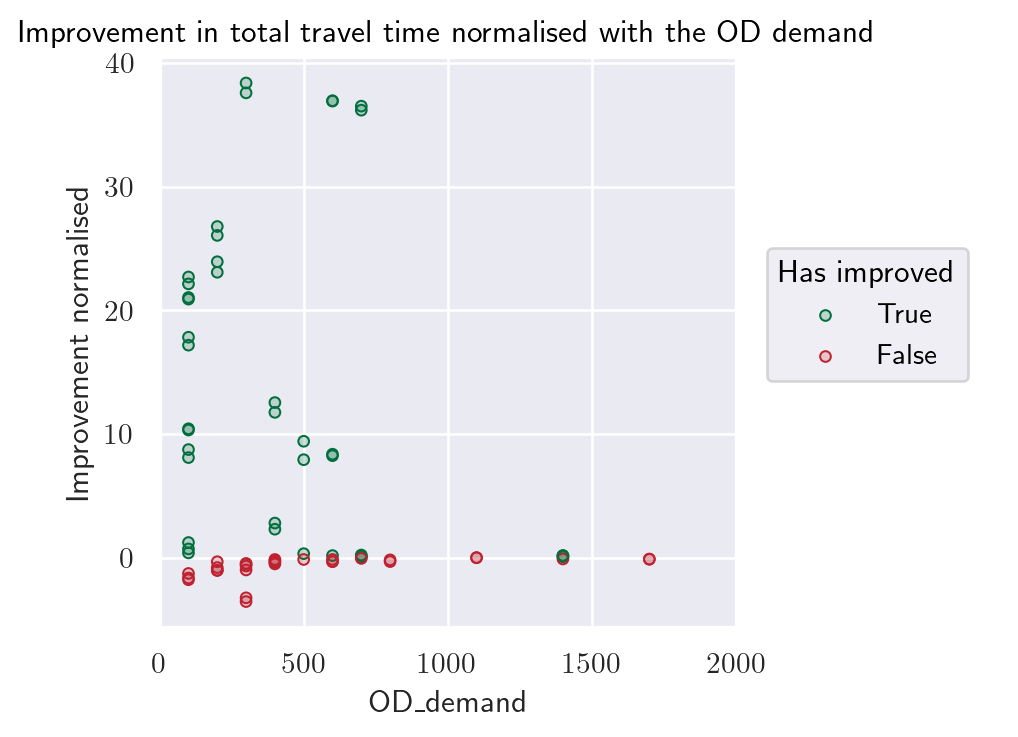

In [10]:
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Improvement normalised")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Dots())
    .limit(x=(0, 2000))
    .label(title="Improvement in total travel time normalised with the OD demand")
    .layout(size=(4, 4))
    .plot()
    .save("figs/results/OD_demand_norm.pgf", bbox_inches = "tight")
)

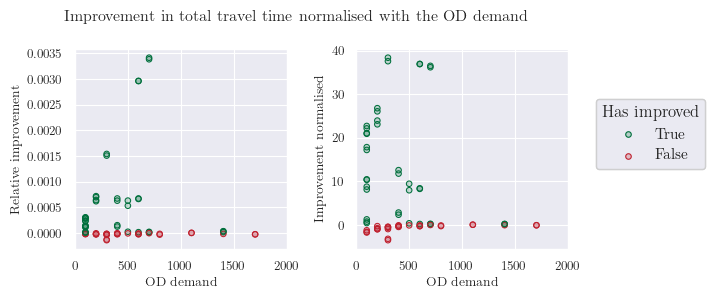

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), layout="tight")
sns.set_theme("paper", "darkgrid", font="serif")
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Relative improvement")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Dots())
    .label(x = "OD demand")
    .limit(x=(0, 2000))
    .on(ax1)
    .plot()
)
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Improvement normalised")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Dots())
    .label(x = "OD demand")
    .limit(x=(0, 2000))
    .on(ax2)
    .plot()
)

plt.suptitle("Improvement in total travel time compared with the OD demand")
plt.savefig("figs/results/OD_demand_both.pgf", bbox_inches = "tight")

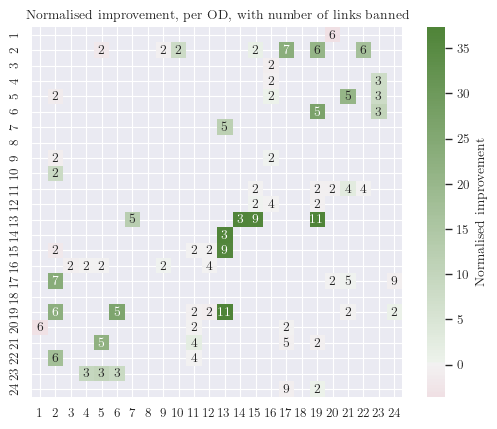

In [31]:
matrix = df.reset_index().pivot(index="o", columns="d", values="Improvement normalised")
matrix = matrix.reindex(pd.RangeIndex(1,25))
matrix = matrix.reindex(pd.RangeIndex(1,25), axis=1)

matrix = matrix.to_numpy()
im = sns.heatmap(matrix,
                annot = mask.sum(axis=2),
                cmap=sns.diverging_palette(0, 120, as_cmap=True),
                cbar_kws=dict(label = "Normalised improvement"),
                vmin = np.nanmin(matrix),
                center=0,
                robust=True,
                square=True,
                xticklabels = np.arange(1,25),
                yticklabels= np.arange(1,25))

plt.title("Normalised improvement, per OD, with number of links banned")
plt.savefig("figs/results/OD_comparison_results_norm.pgf", bbox_inches="tight")

#### Number of removed links

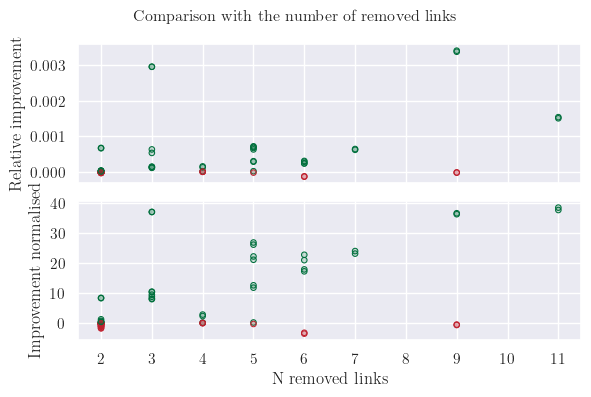

In [47]:
(
    so.Plot(data=df, color="Has improved", x="N removed links")
    .pair(y = ["Relative improvement", "Improvement normalised"])
    .scale(color="blend:#006f3c,#bf212f", x=so.Continuous().tick(every=1))
    .add(so.Dots(), legend=False)
    .layout(size=(6, 4), engine="tight")
    .plot(pyplot=True)
)
plt.suptitle("Comparison with the number of removed links")
plt.savefig("figs/results/N_removed.pgf", bbox_inches="tight")

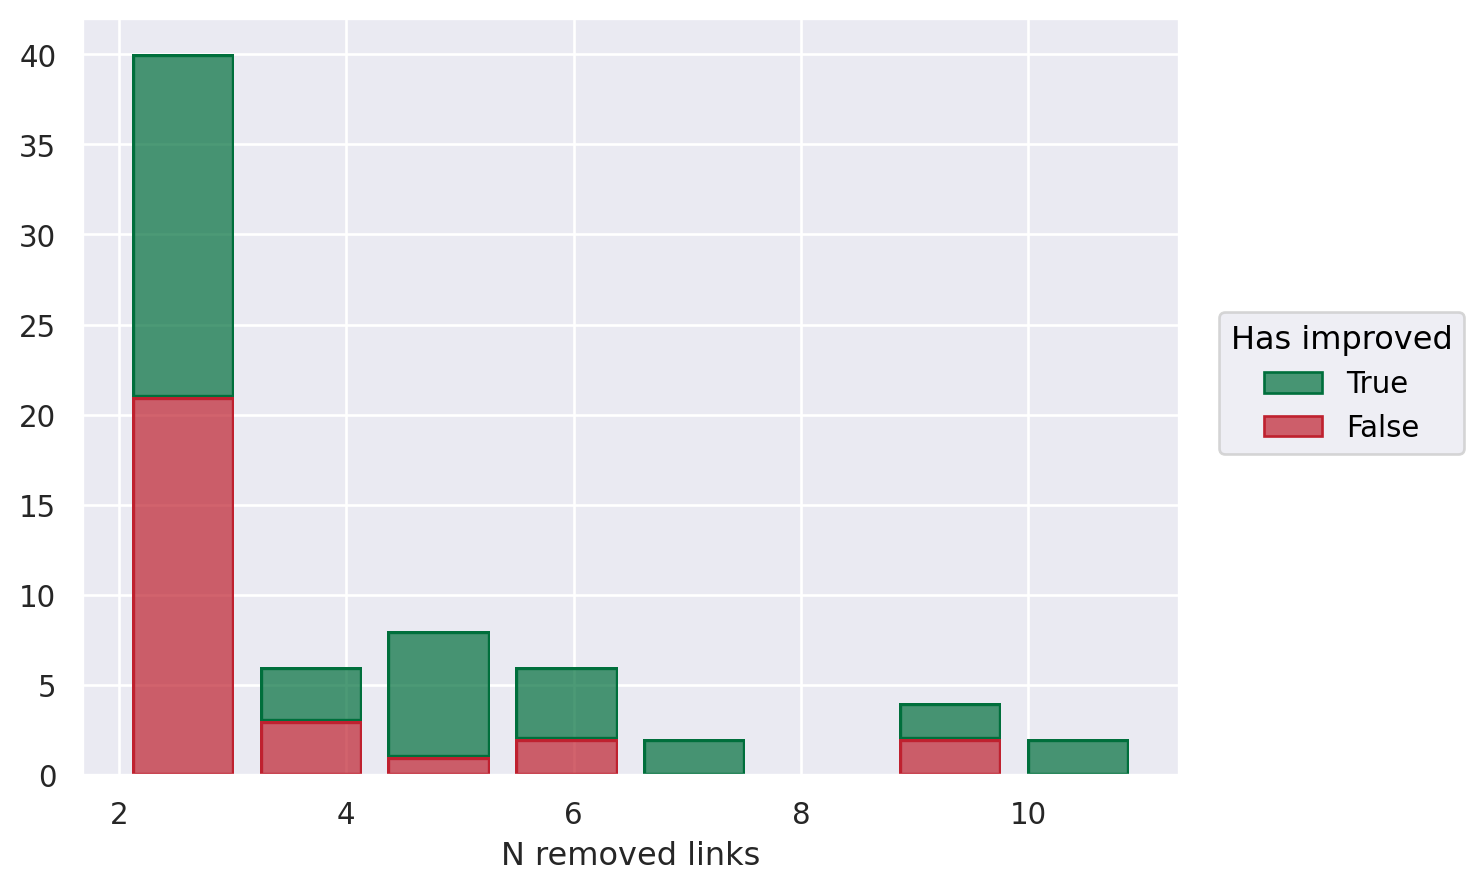

In [165]:
(
    so.Plot(data=df, color="Has improved", x="N removed links")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Bar(), so.Hist(), so.Stack())
)

#### OD UE flows on banned links

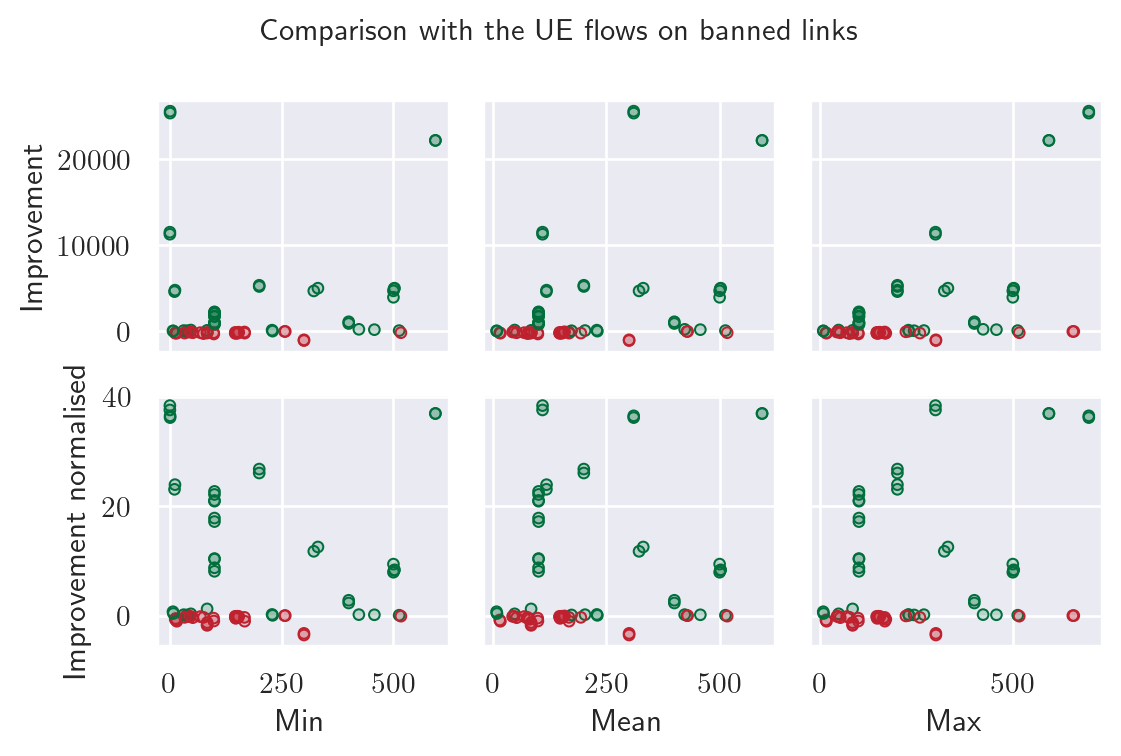

In [95]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['min_UE_flow_on_banned_links', 'mean_UE_flow_on_banned_links', 'max_UE_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .layout(size=(6,5))
    .add(so.Dots(), legend=False)
    .plot()
)
p._figure.suptitle("Comparison with the UE flows on banned links")
p.save("figs/results/UE_flow_ban.pgf", bbox_inches="tight")

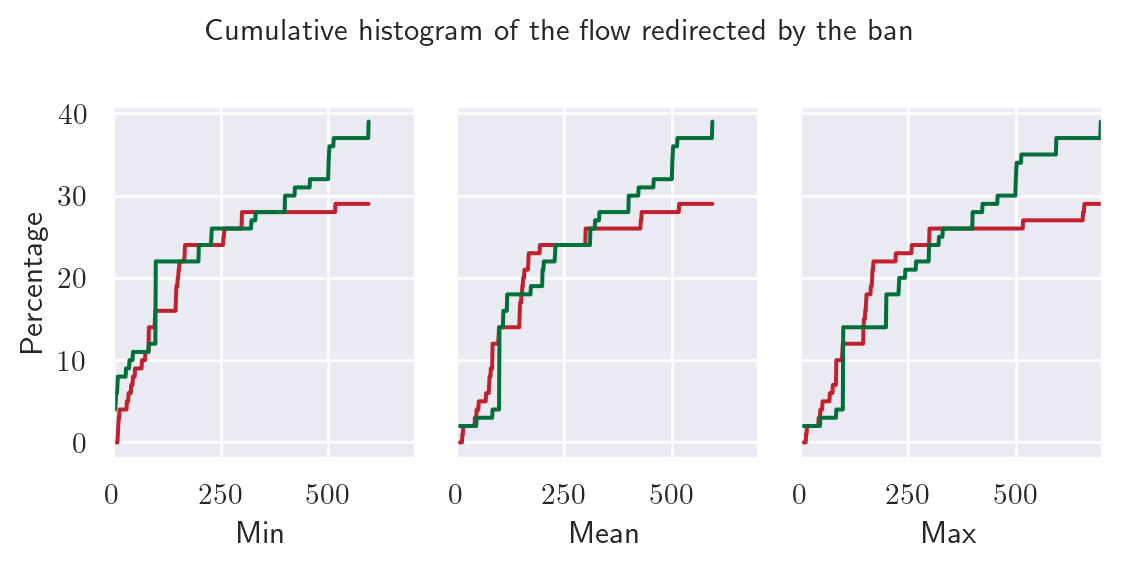

In [94]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_UE_flow_on_banned_links', 'mean_UE_flow_on_banned_links', 'max_UE_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max", y="Percentage")
    .share(x=True)
    .limit(x=(0, 700))
    .layout(size=(6,3))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=1), legend=False)
    .plot()
)
p._figure.suptitle("Cumulative histogram of the flow redirected by the ban")
p.save("figs/results/cumulative.pgf", bbox_inches = "tight")

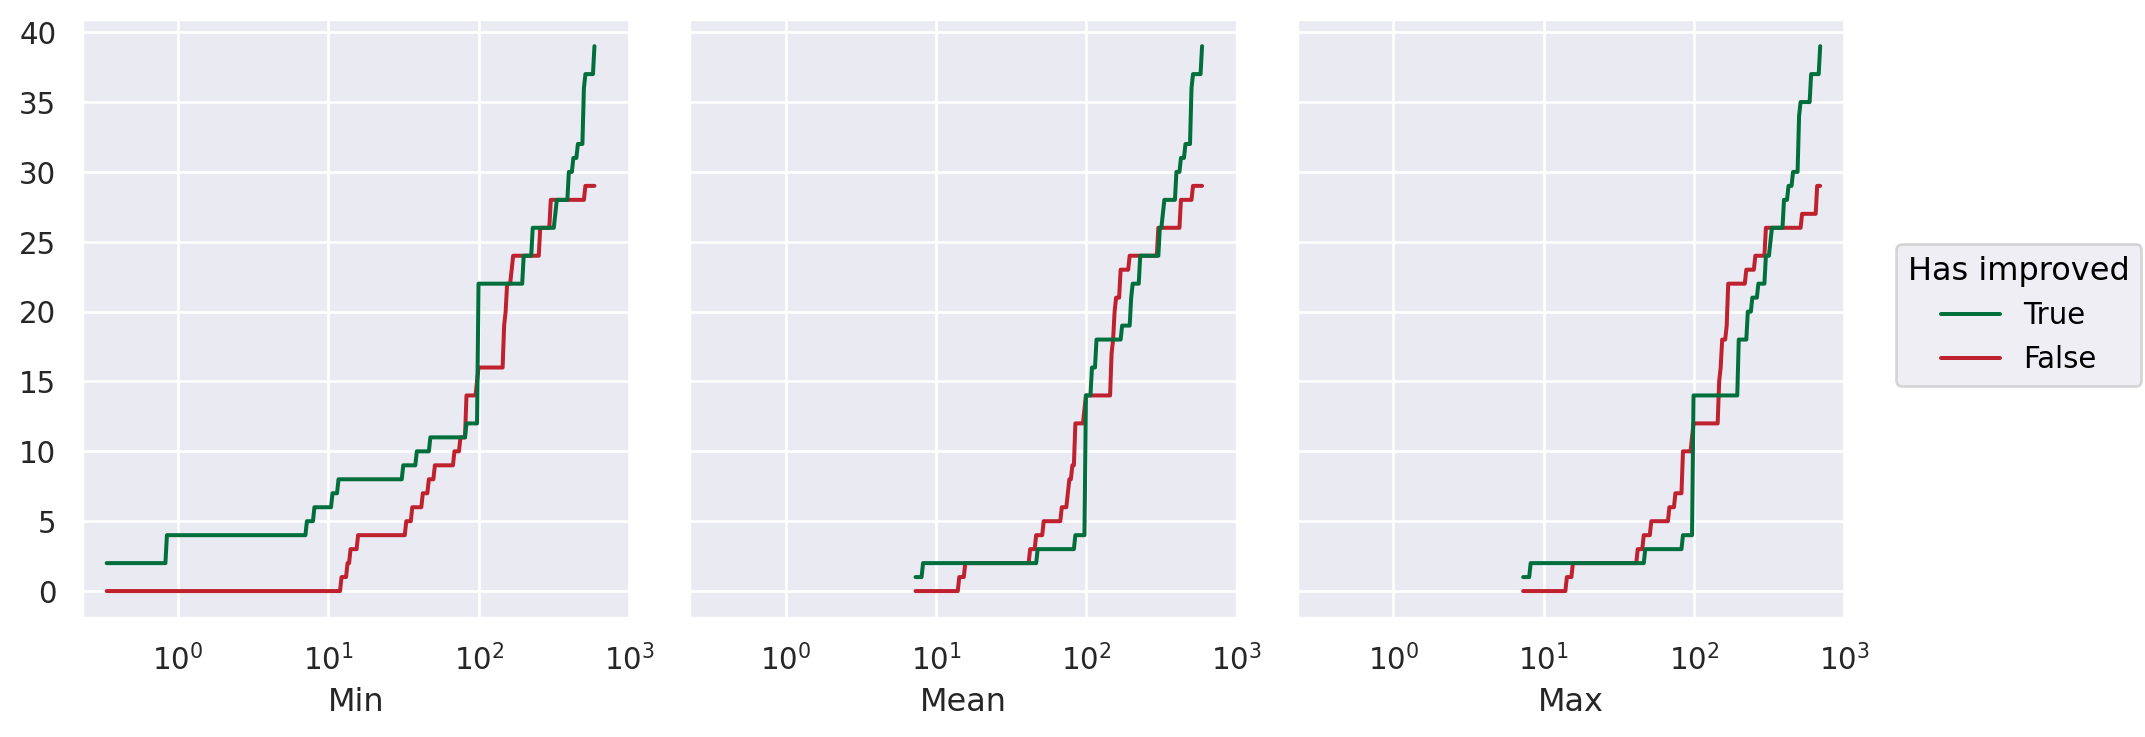

In [206]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_UE_flow_on_banned_links', 'mean_UE_flow_on_banned_links', 'max_UE_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f", x="log")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,4))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=0.01))
)

#### Paths impacted

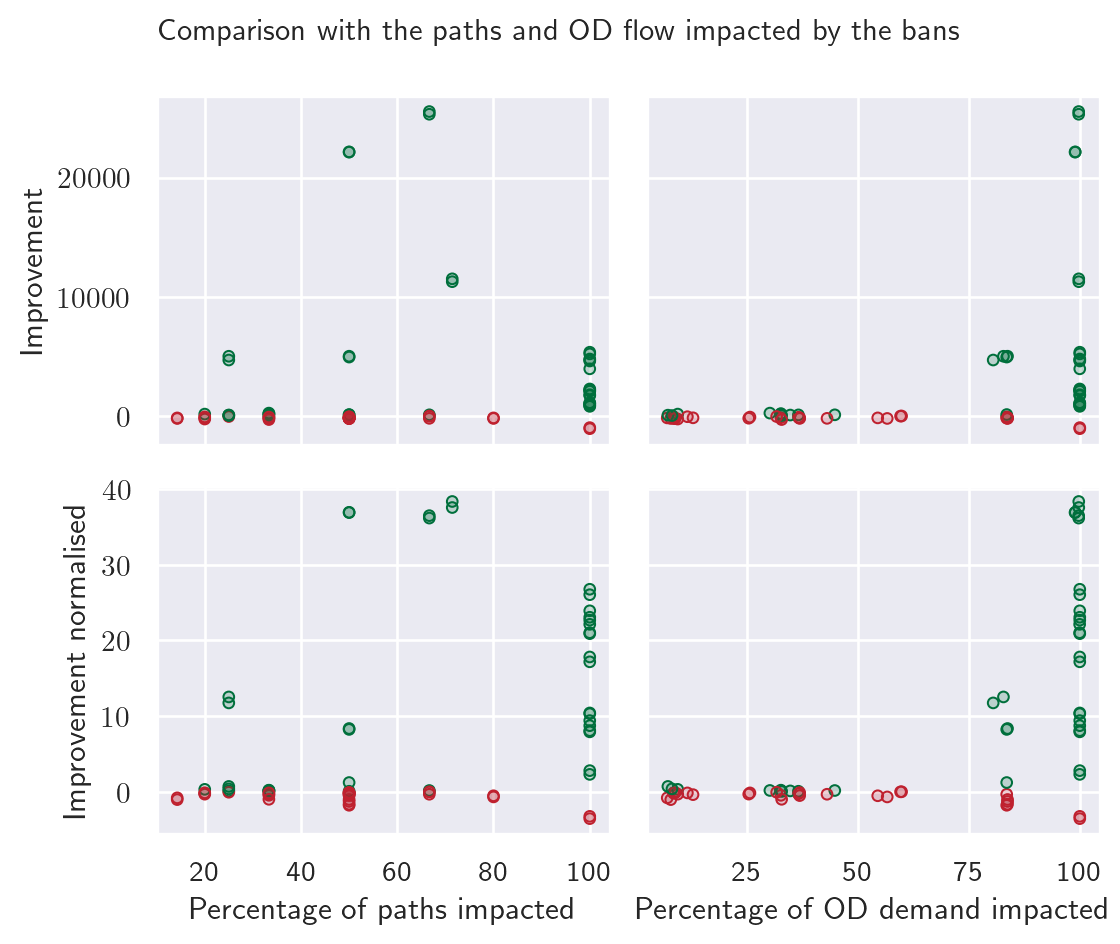

In [104]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['percentage_OD_paths_impacted', 'percentage_OD_demand_impacted'])
    .scale(color="blend:#006f3c,#bf212f", x=so.Continuous().label(like = lambda x, pos: f"{x*100:.0f} %"))
    .layout(size=(6,5))
    .add(so.Dots(), legend=False)
    .label(x0 = "Percentage of paths impacted", x1 = "Percentage of OD demand impacted")
    .plot()
)
p._figure.suptitle("Comparison with the paths and OD flow impacted by the bans")
p.save("figs/results/percentage_paths_flow.pgf", bbox_inches="tight")

#### Betweeness centrality

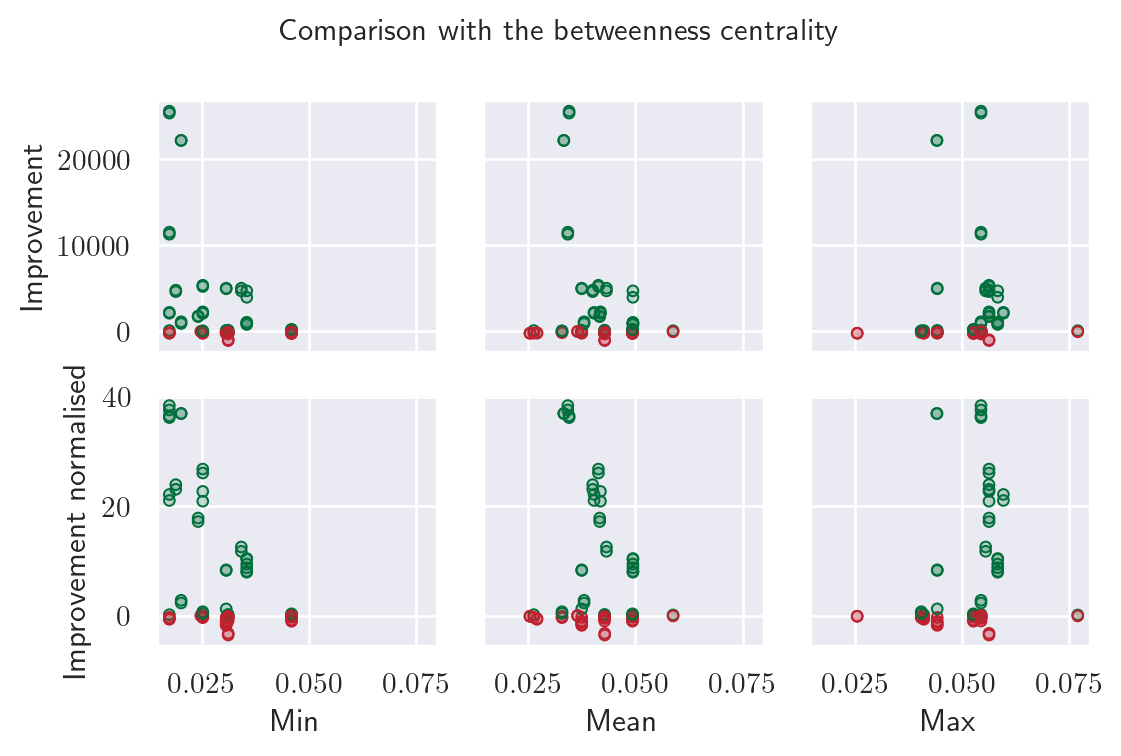

In [106]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['min_betweenness_centrality', 'mean_betweenness_centrality', 'max_betweenness_centrality'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x = True)
    .layout(size=(6,4))
    .add(so.Dots(), legend=False)
    .plot()
)
p._figure.suptitle("Comparison with the betweenness centrality")
p.save("figs/results/betweenness_centrality.pgf", bbox_inches="tight")

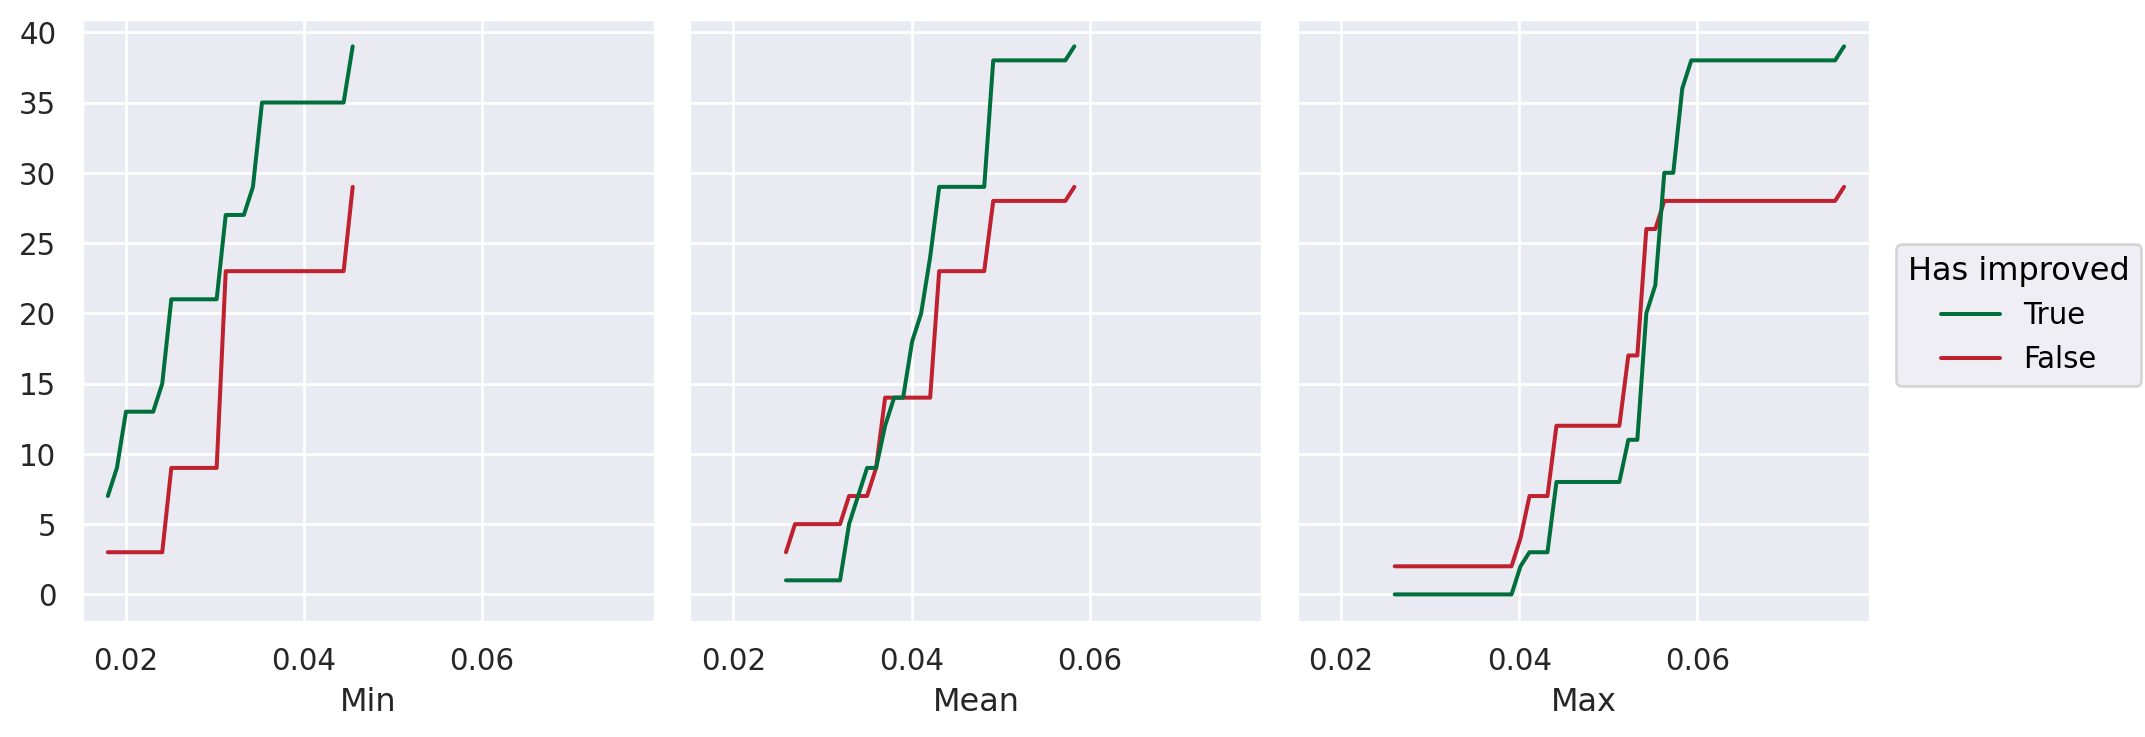

In [223]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_betweenness_centrality', 'mean_betweenness_centrality', 'max_betweenness_centrality'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,4))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=0.001))
)

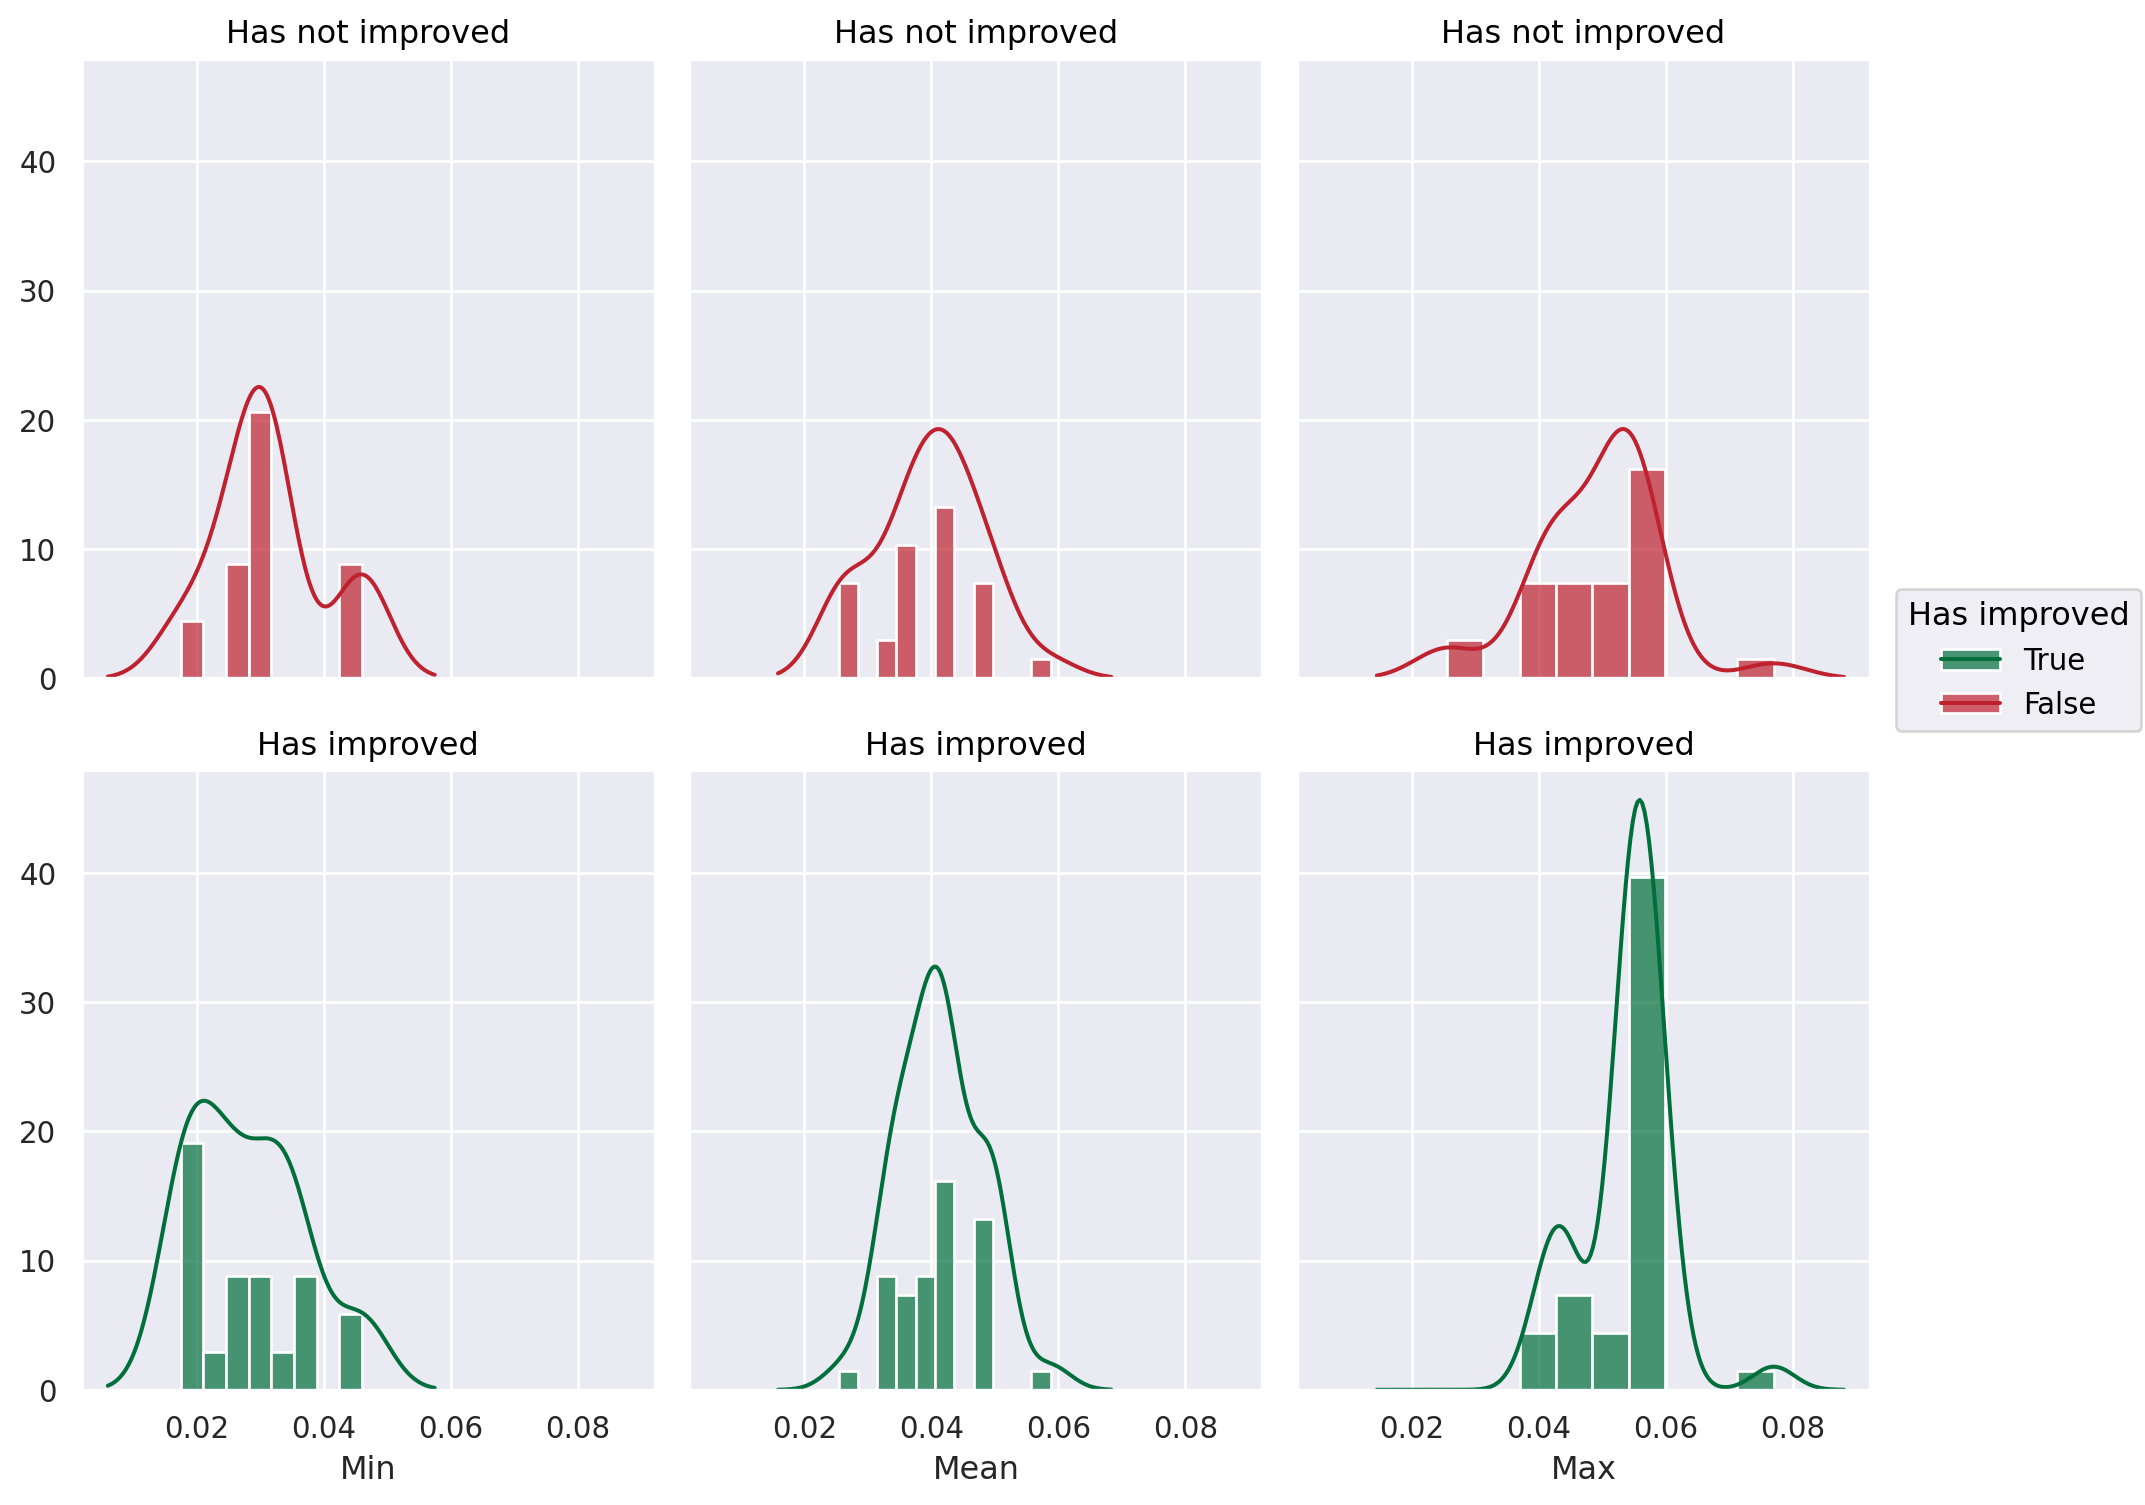

In [239]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_betweenness_centrality', 'mean_betweenness_centrality', 'max_betweenness_centrality'])
    .facet(row=df["Has improved"].apply(lambda x : "Has improved" if x else "Has not improved"))
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,8))
    .add(so.Bars(), so.Hist("percent"))
    .add(so.Line(), so.KDE())
)

#### Total flow on impacted links

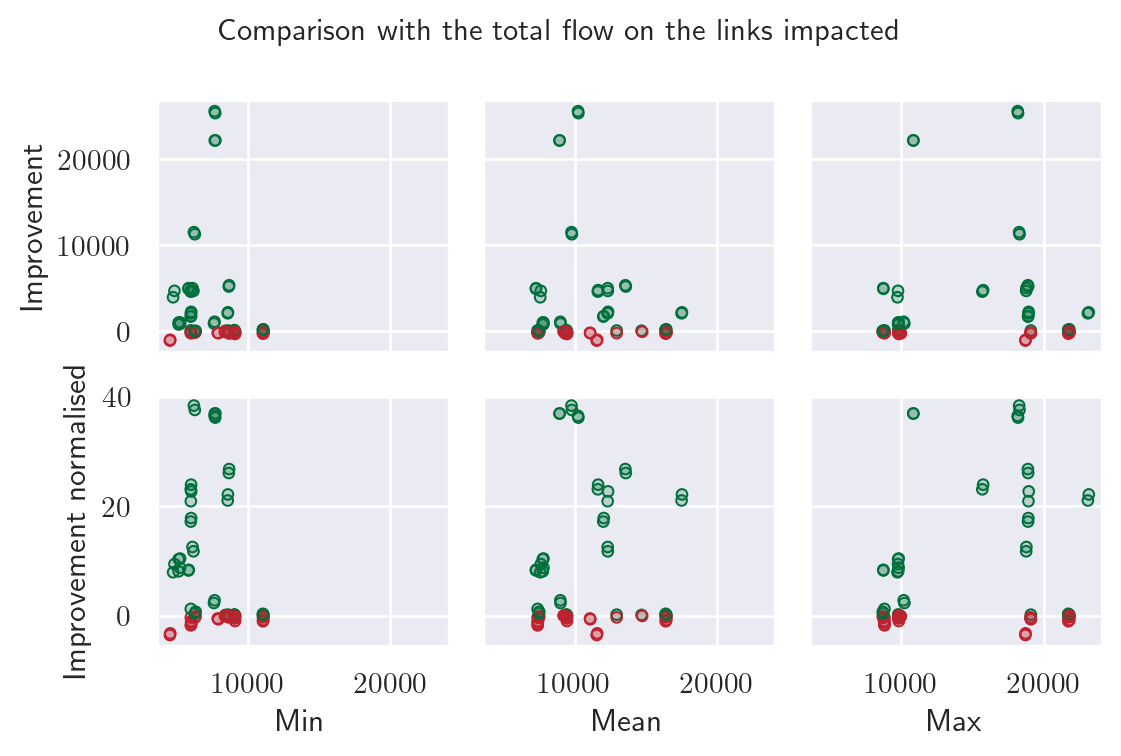

In [107]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['min_total_flow_on_banned_links', 'mean_total_flow_on_banned_links', 'max_total_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x = True)
    .layout(size=(6,4))
    .add(so.Dots(), legend=False)
    .plot()
)
p._figure.suptitle("Comparison with the total flow on the links impacted")
p.save("figs/results/total_flow.pgf", bbox_inches= "tight")

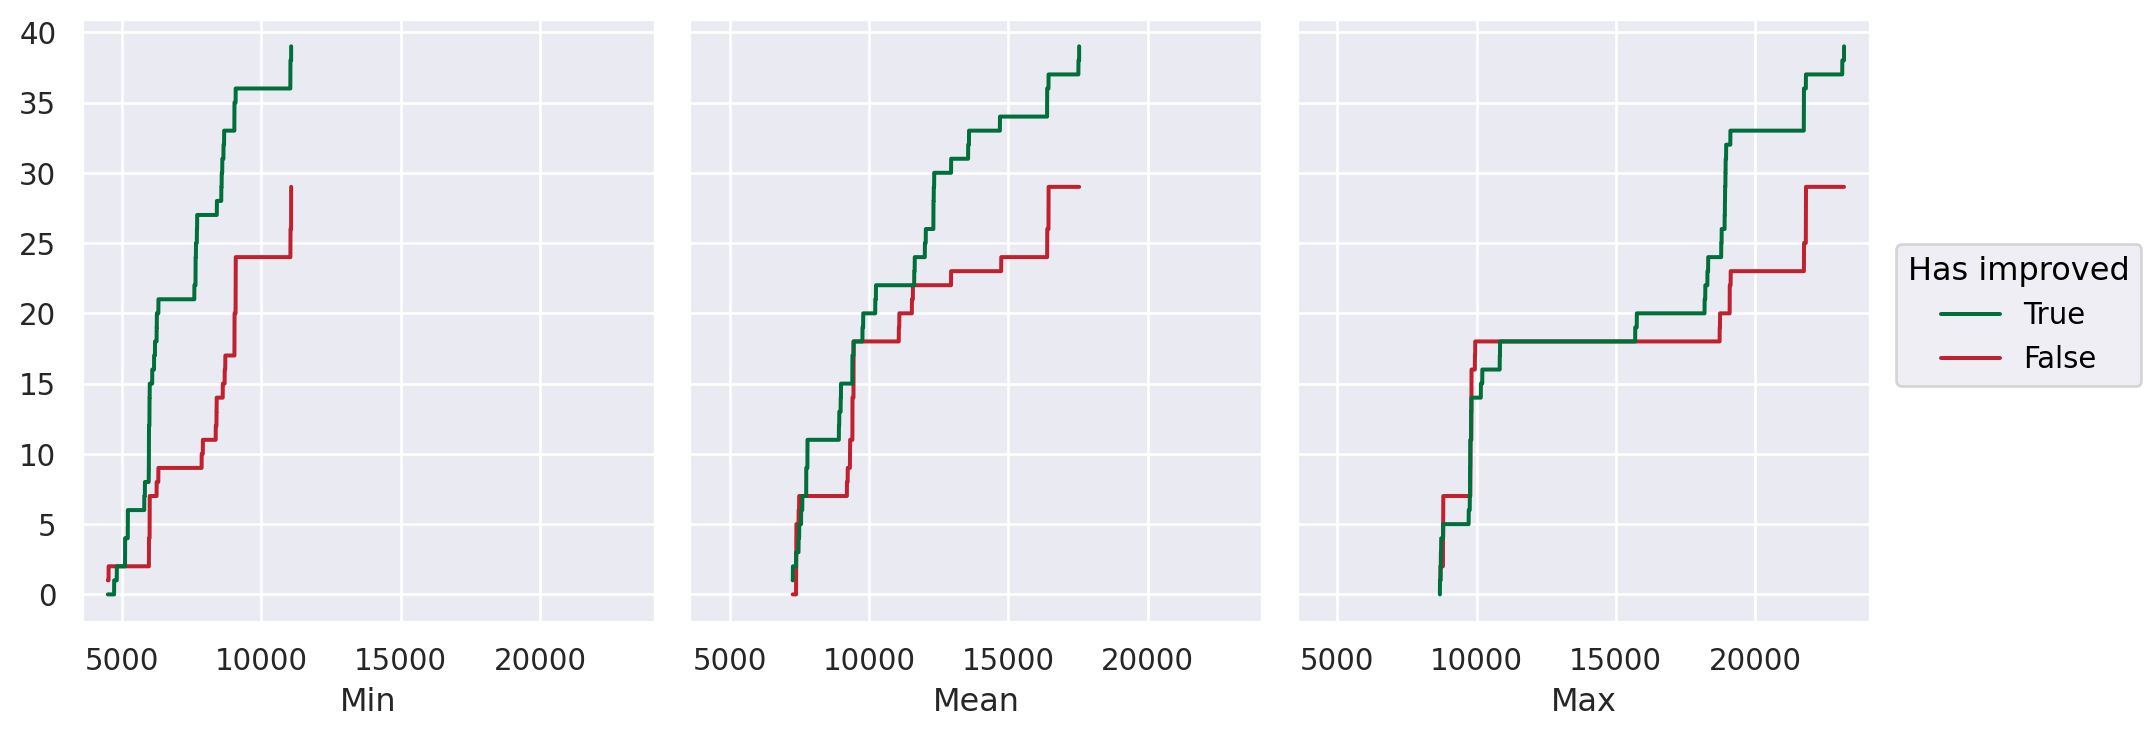

In [244]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_total_flow_on_banned_links', 'mean_total_flow_on_banned_links', 'max_total_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,4))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=1))
)

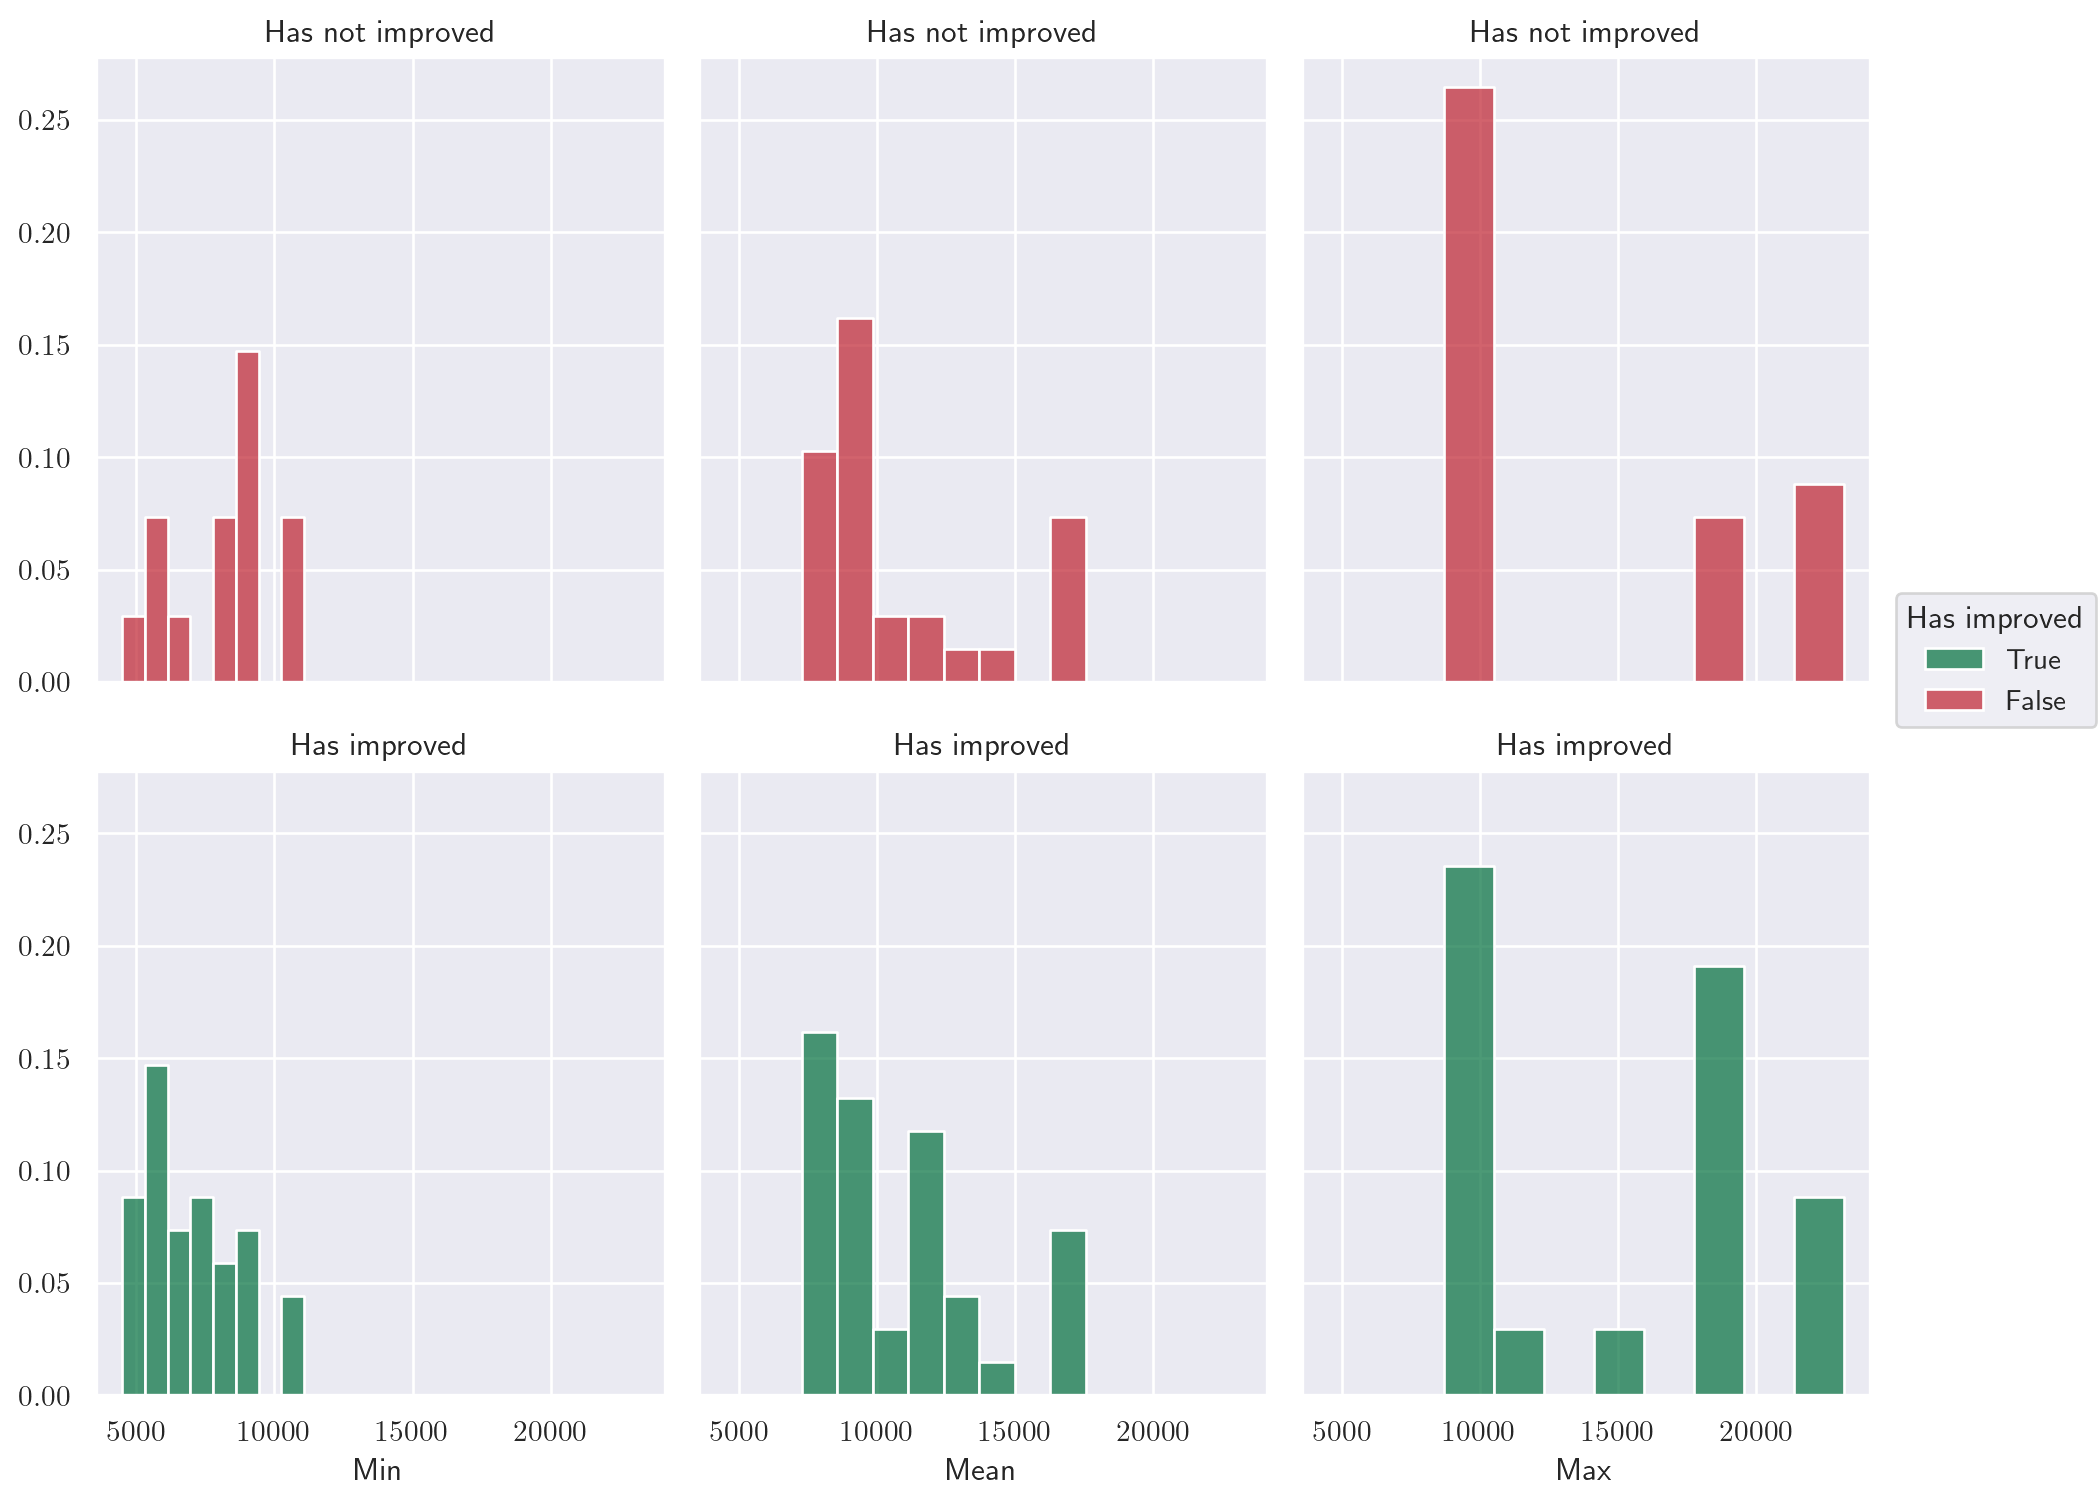

In [108]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_total_flow_on_banned_links', 'mean_total_flow_on_banned_links', 'max_total_flow_on_banned_links'])
    .facet(row=df["Has improved"].apply(lambda x : "Has improved" if x else "Has not improved"))
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,8))
    .add(so.Bars(), so.Hist("proportion"))
    #.add(so.Line(), so.KDE())
)

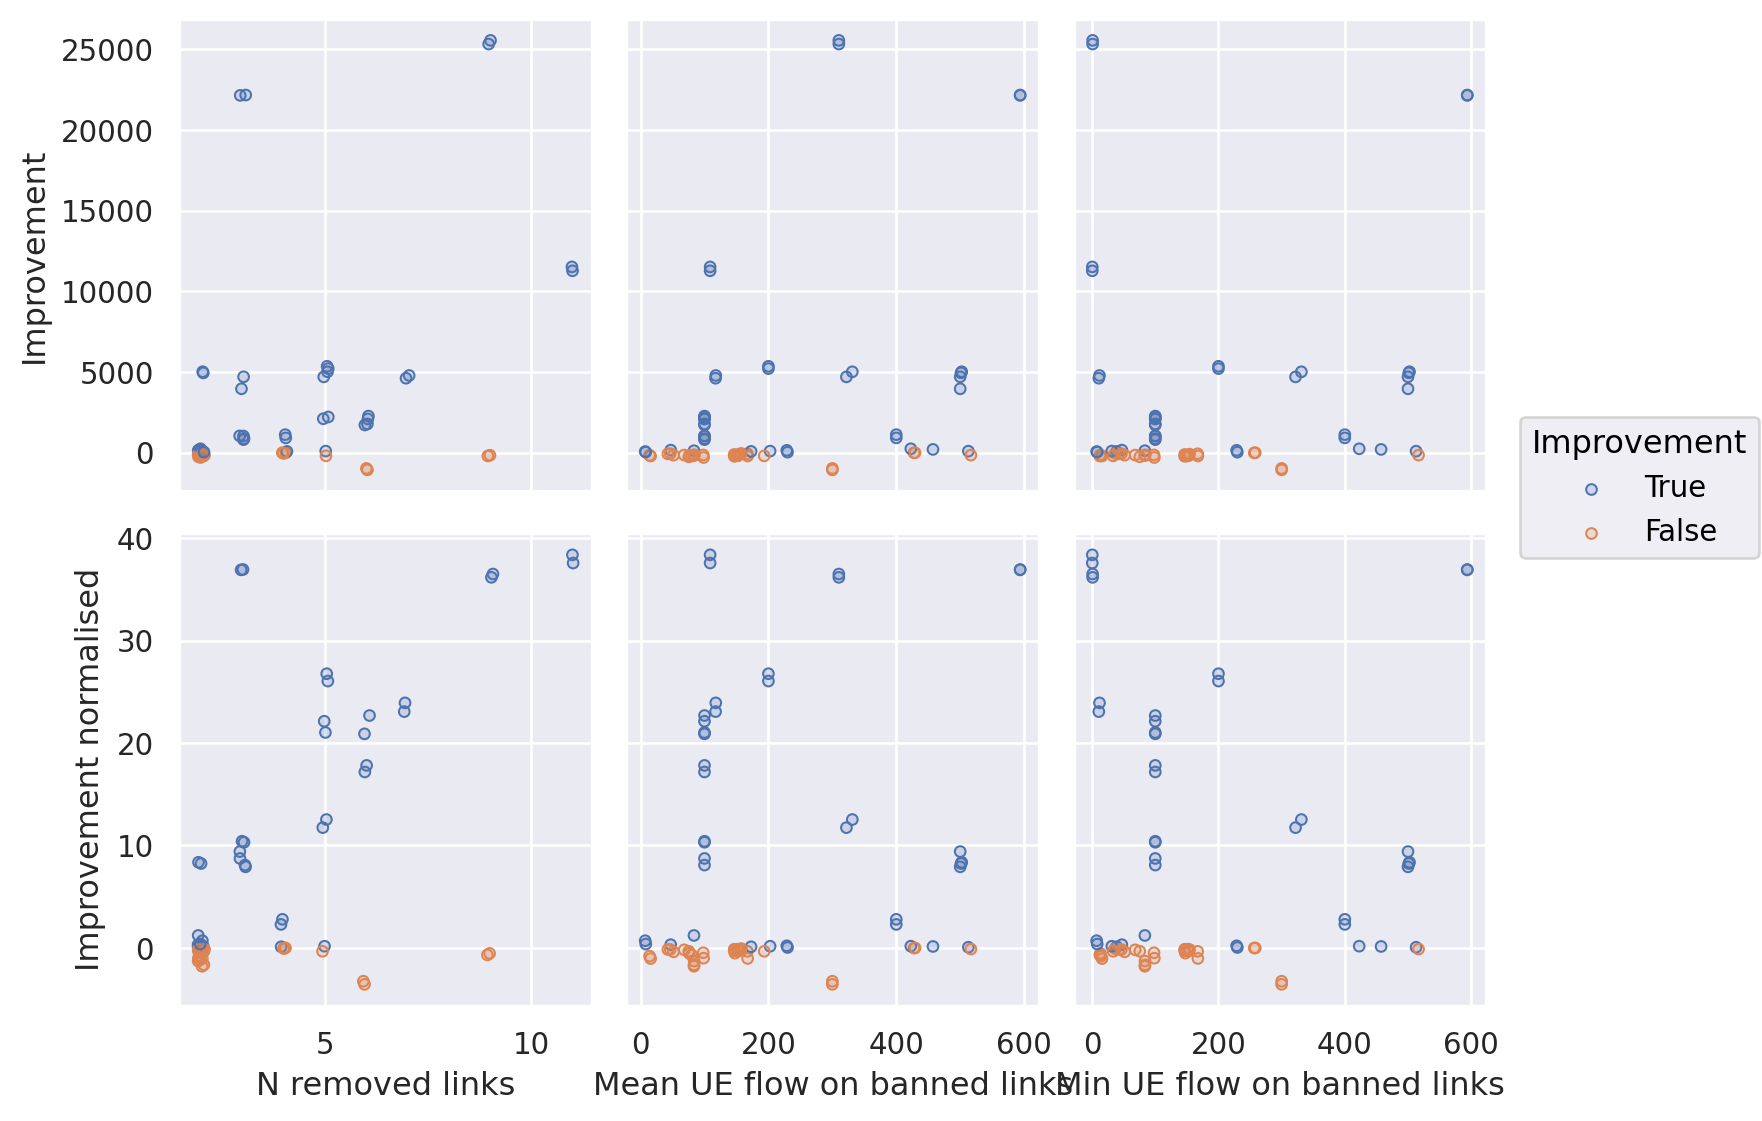

In [25]:
(
    so.Plot(data=df, color=df["Improvement"]>0)
    .pair(x=["N removed links", "mean_UE_flow_on_banned_links", "min_UE_flow_on_banned_links"], y= ["Improvement", "Improvement normalised"])
    .add(so.Dots(), so.Jitter())
    .layout(size=(8,6))
    .label(x1 = "Mean UE flow on banned links", x2 = "Min UE flow on banned links")
    .plot()
)

In [52]:
df["Has improved"].mean()

0.5735294117647058

In [53]:
df.sort_values("Improvement", ascending=False).head(5)

Total travel time   Improvement  N removed links  \
o  d                                                      
13 15       7.454079e+06  25546.846915                9   
15 13       7.454306e+06  25319.691535                9   
14 13       7.457464e+06  22161.990970                3   
13 14       7.457486e+06  22140.299024                3   
   19       7.468115e+06  11510.331430               11   

                                     Banned links  \
o  d                                                
13 15          34, 39, 41, 65, 67, 71, 72, 75, 76   
15 13          40, 42, 44, 46, 66, 69, 70, 73, 74   
14 13                                  42, 73, 74   
13 14                                  39, 71, 76   
   19  34, 39, 41, 61, 64, 65, 67, 71, 72, 75, 76   

                                UE_flows_on_banned_links  \
o  d                                                       
13 15  [0.8461428469094254, 697.4102676451174, 79.818...   
15 13  [0.834699104074531, 80.61615592340895, 81.4508...   
14 13  [593.8512484804402, 593.8512484804402, 593.851...   
13 14  [593.6394925299081, 593.6394925299081, 593.639...   
   19  [0.33320814727964254, 298.9801253489016, 31.43...   

       mean_UE_flow_on_banned_links  min_UE_flow_on_banned_links  \
o  d                                                               
13 15                    310.148151                     0.846143   
15 13                    310.167099                     0.834699   
14 13                    593.851248                   593.851248   
13 14                    593.639493                   593.639493   
   19                    108.780629                     0.333208   

       max_UE_flow_on_banned_links  OD_demand  Improvement normalised  \
o  d                                                                    
13 15                   697.410268      700.0               36.495496   
15 13                   697.458624      700.0               36.170988   
14 13                   593.851248      600.0               36.936652   
13 14                   593.639493      600.0               36.900498   
   19                   298.980125      300.0               38.367771   

       Has improved  Sort  
o  d                       
13 15          True  1 OD  
15 13          True  1 OD  
14 13          True  1 OD  
13 14          True  1 OD  
   19          True  1 OD

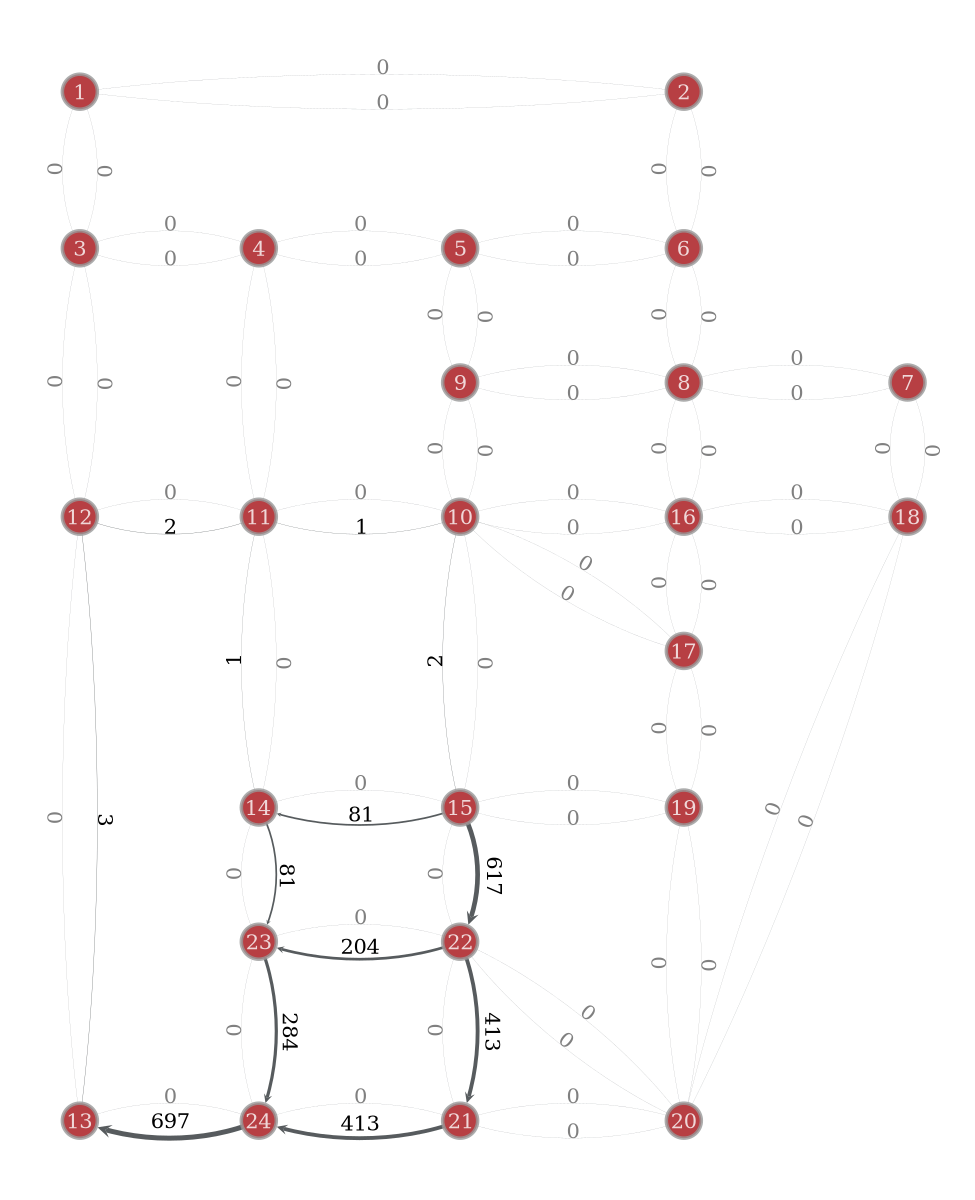

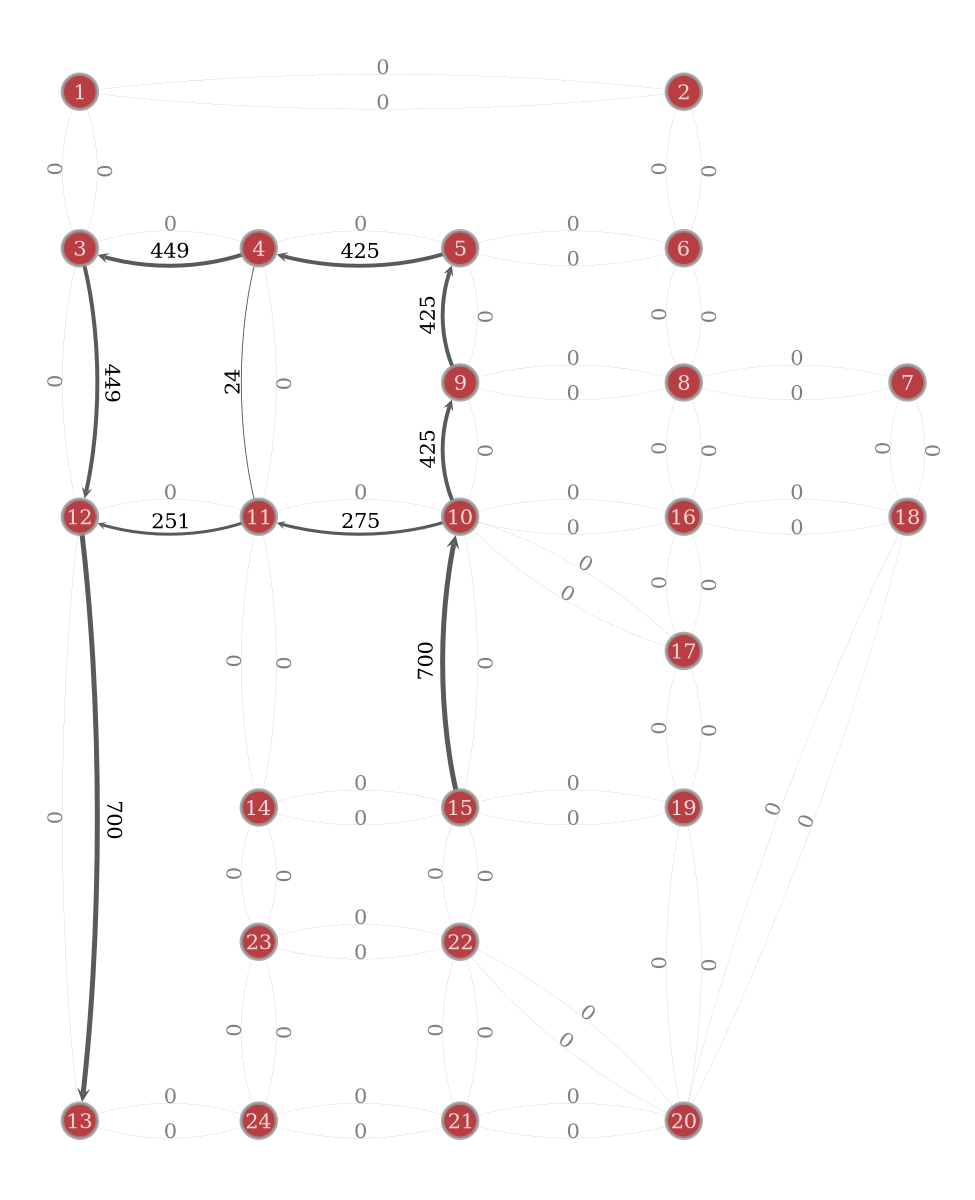

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f19153f0380, at 0x7f18eee1ede0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f19153f0380, at 0x7f18ef137980>)

In [54]:
net.draw(flows_by_OD=UE_OD_flows, d=13, o=15), net.draw(flows_by_OD=SO_OD_flows, d=13, o=15)

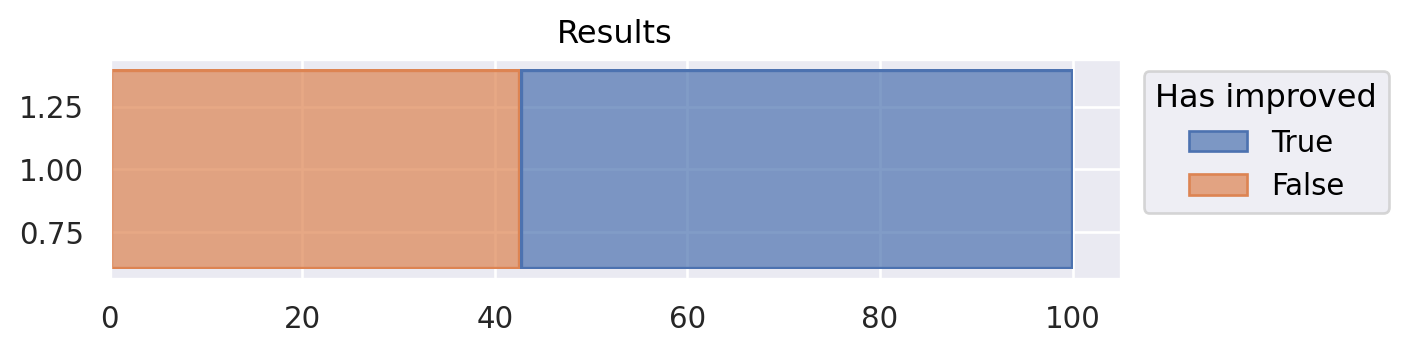

In [51]:
(
    so.Plot(data=df, y=1, color="Has improved")
    .add(so.Bar(), so.Hist(stat="percent"), so.Stack())
    .label(title="Results")
    .layout(size=(6, 2))
    .plot()
)

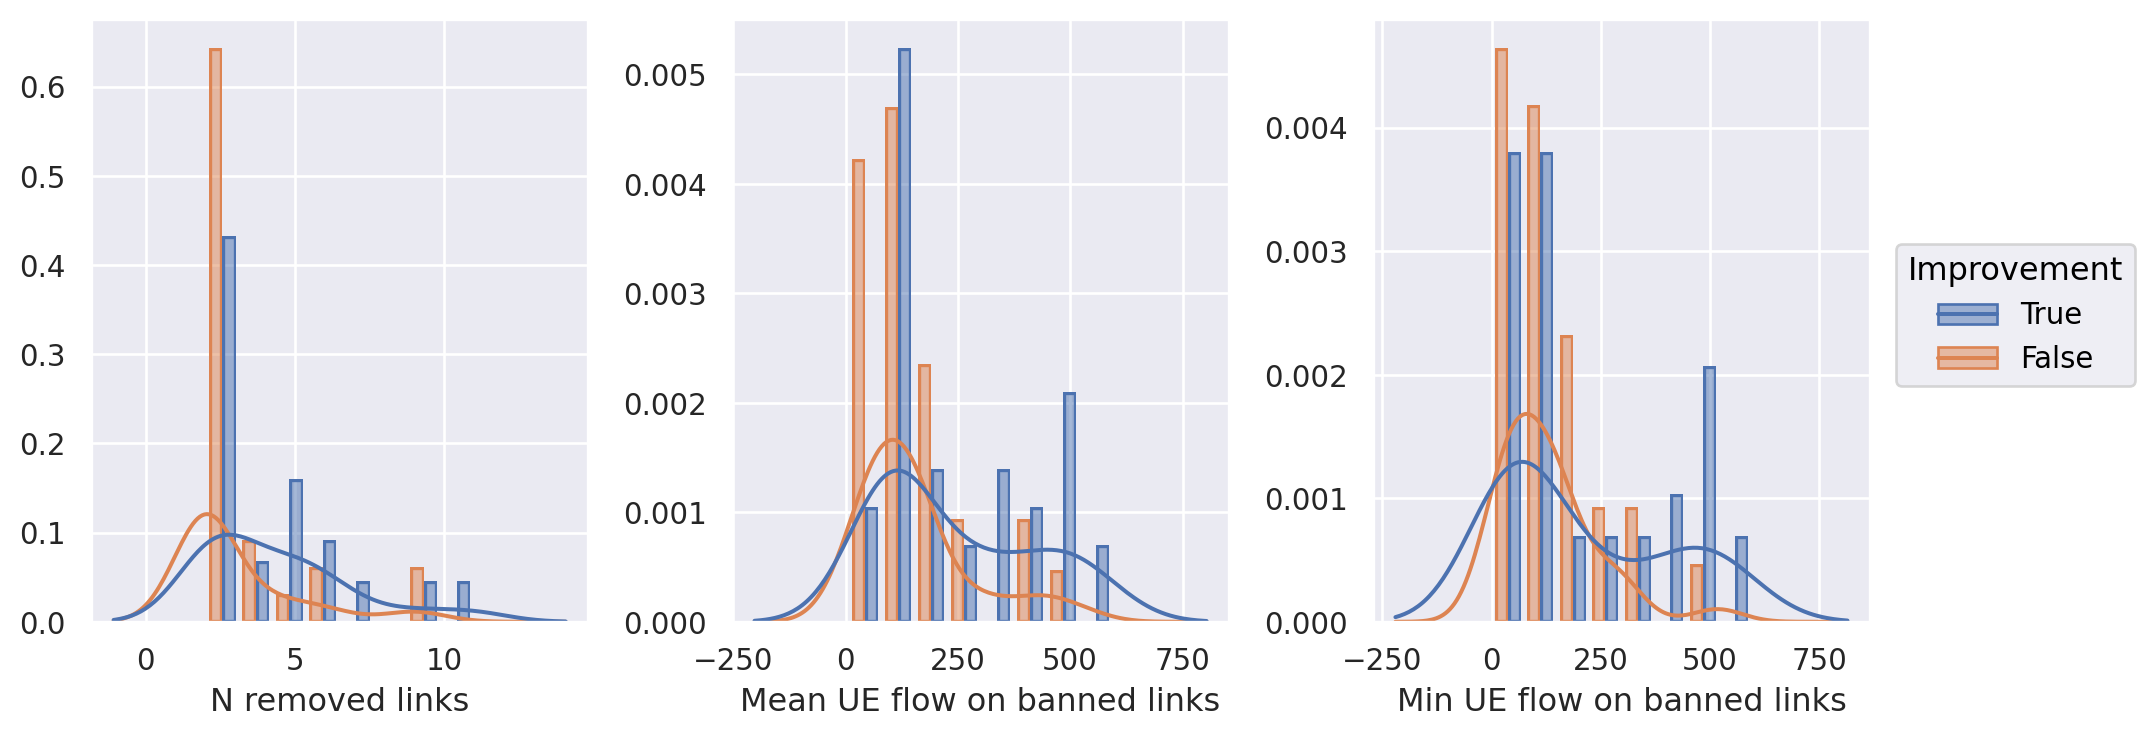

In [26]:
(
    so.Plot(data=df, color=df["Improvement"]>0)
    .pair(x=["N removed links", "mean_UE_flow_on_banned_links", "min_UE_flow_on_banned_links"])
    .add(so.Bar(alpha=0.5), so.Hist(stat="density"), so.Dodge())
    .add(so.Line(), so.KDE())
    .layout(size=(10,4))
    .share(y=False)
    .label(x1 = "Mean UE flow on banned links", x2 = "Min UE flow on banned links")
    .plot()
)

<Axes: xlabel='Improvement', ylabel='mean_UE_flow_on_banned_links'>

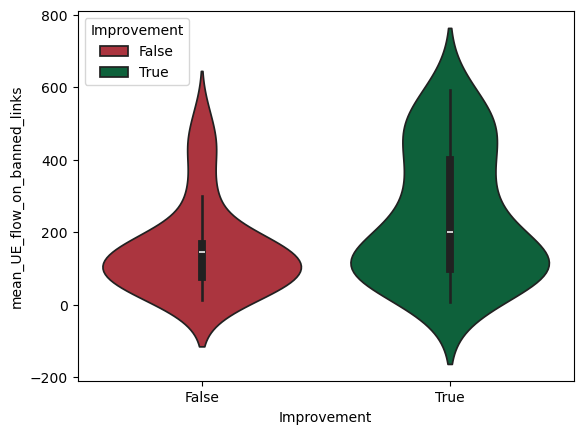

In [27]:
sns.violinplot(data=df, hue = df.Improvement>0, x=df.Improvement  > 0,  y="mean_UE_flow_on_banned_links", palette="blend:#bf212f,#006f3c")

In [28]:
df["Has improved"] = df["Improvement"] > 0

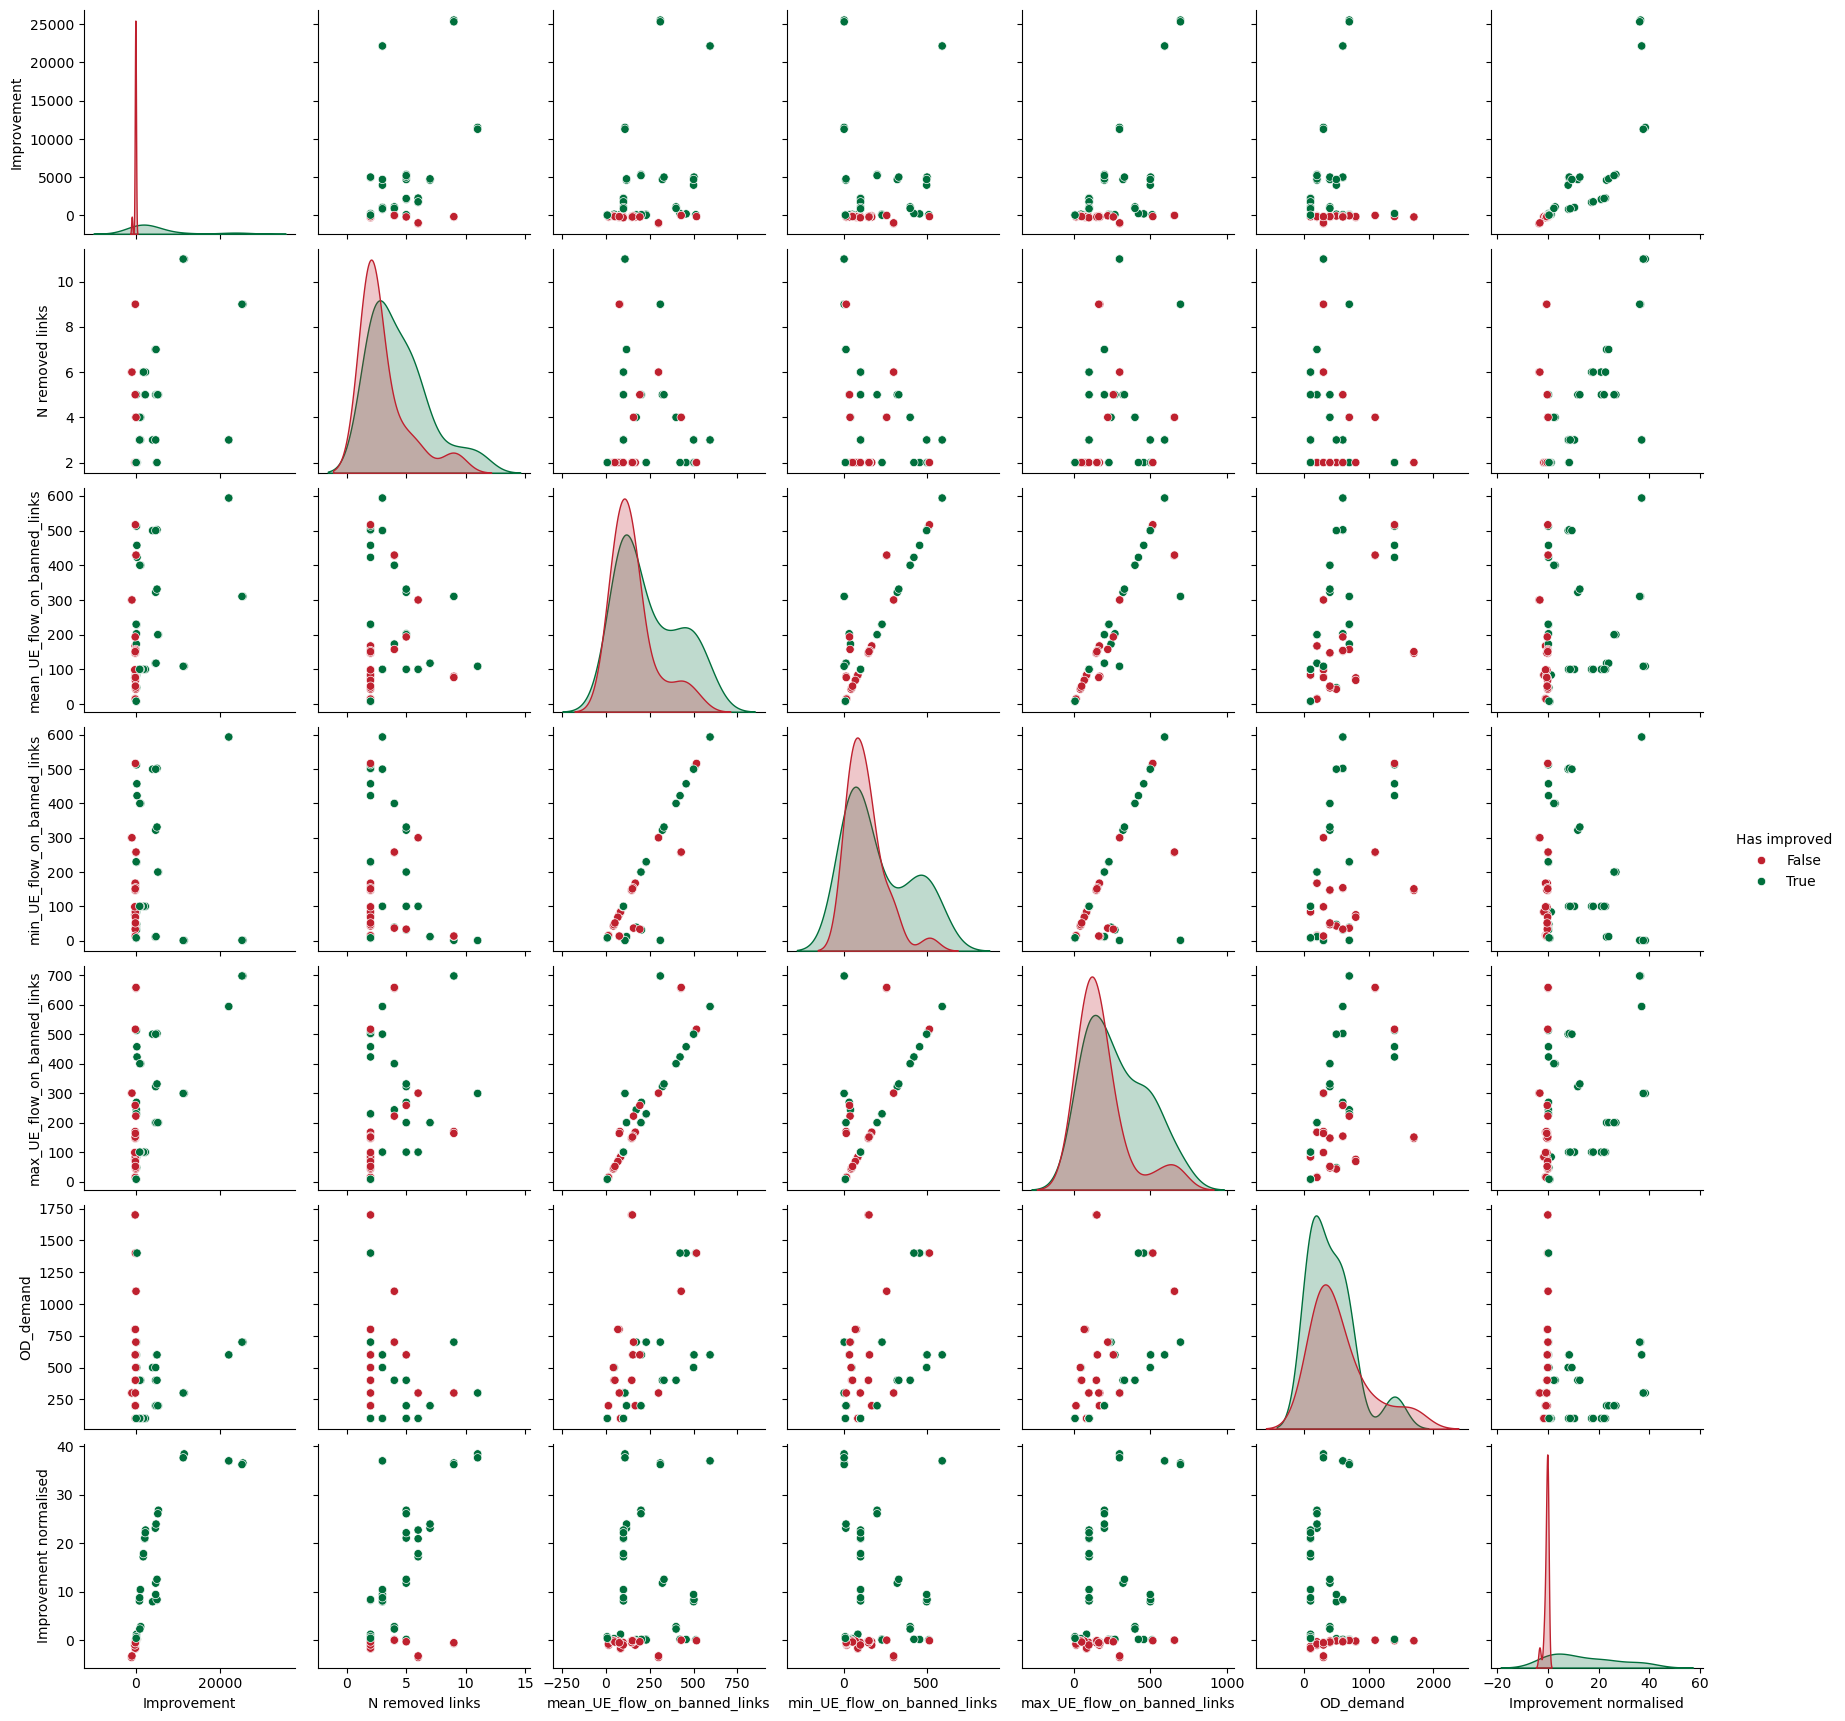

In [29]:
g= sns.pairplot(df[["Improvement", "N removed links", "mean_UE_flow_on_banned_links", "min_UE_flow_on_banned_links", "max_UE_flow_on_banned_links", "OD_demand", "Improvement normalised", "Has improved"]], hue="Has improved", palette="blend:#bf212f,#006f3c")

In [34]:
# Now, analyse results when banning links for the whole network
flows = net.load_flow(f"fw_p4", folder="files/precision", dim=1)
original_ttt = float(compute_total_travel_time(net, flows))
print("original total travel time :", original_ttt)
records = {}
for link in tqdm(OD_per_links[OD_per_links>0].dropna(axis=1).sort_values("Number of ODs", axis = 1, ascending= False).columns):
    try:
        flows = net.load_flow(f"n1_l{link-1}", dim=1, folder="files/masked/no_threshold")
        ttt = compute_total_travel_time(net, flows)
        records[link] = {
            "Total travel time": float(ttt),
            "Improvement": original_ttt - float(ttt),
            "UE_flows_on_banned_link": UE_OD_flows[:, :, link-1].sum(),
            "min_UE_flow_on_banned_link" : UE_OD_flows[:, :, link-1].min(),
            "max_UE_flow_on_banned_link" : UE_OD_flows[:, :, link-1].max(),
            "Has improved": bool((original_ttt - float(ttt))>0)
        }
    except ValueError:
        print(f"Link {link} not found")
df2 = pd.DataFrame.from_dict(records, orient="index")
df2.index.set_names(["Link banned"], inplace=True)
df2

original total travel time : 7479625.830083258


100%|██████████| 62/62 [00:00<00:00, 229.66it/s]


[('SiouxFalls', 'n1_l14'), ('SiouxFalls', 'n1_l2'), ('SiouxFalls', 'n4_l39_41_43_60'), ('SiouxFalls', 'o23d16'), ('SiouxFalls', 'n3_l33_39_40'), ('SiouxFalls', 'n1_l25'), ('SiouxFalls', 'o14d1'), ('SiouxFalls', 'o20d18'), ('SiouxFalls', 'o18d5'), ('SiouxFalls', 'o11d18'), ('SiouxFalls', 'o1d18'), ('SiouxFalls', 'o18d20'), ('SiouxFalls', 'n6_l39_41_43_60_13_24'), ('SiouxFalls', 'o19d0'), ('SiouxFalls', 'n1_l58'), ('SiouxFalls', 'o18d11'), ('SiouxFalls', 'n1_l71'), ('SiouxFalls', 'o18d10'), ('SiouxFalls', 'o23d18'), ('SiouxFalls', 'n1_l30'), ('SiouxFalls', 'o18d23'), ('SiouxFalls', 'n1_l25'), ('SiouxFalls', 'o12d18'), ('SiouxFalls', 'n1_l61'), ('SiouxFalls', 'n8_l39_41_43_60_13_24_53_55'), ('SiouxFalls', 'o19d0'), ('SiouxFalls', 'o18d12'), ('SiouxFalls', 'n1_l1'), ('SiouxFalls', 'o1d14'), ('SiouxFalls', 'n10_l33_40_70_58_3_17_25_45_66_72'), ('SiouxFalls', 'n1_l44'), ('SiouxFalls', 'o12d18'), ('SiouxFalls', 'n13_l33_40_70_58_3_17_25_45_66_72_68_18_59'), ('SiouxFalls', 'n1_l65'), ('SiouxFa

Total travel time   Improvement  UE_flows_on_banned_link  \
Link banned                                                             
34                8.405542e+06 -9.259166e+05              9776.121895   
40                8.412102e+06 -9.324759e+05              9814.056785   
41                8.078480e+06 -5.988540e+05              9036.292997   
42                7.926255e+06 -4.466294e+05              8400.375150   
71                7.924018e+06 -4.443922e+05              8394.837234   
44                8.085939e+06 -6.063136e+05              9079.770228   
59                7.891506e+06 -4.118798e+05              8688.311432   
61                7.891479e+06 -4.118536e+05              8710.591472   
4                 7.724969e+06 -2.453433e+05              5967.321687   
14                7.728193e+06 -2.485676e+05              5991.724783   
18                8.698432e+06 -1.218807e+06             15794.021610   
25                9.967693e+06 -2.488067e+06             21744.060178   
26                1.001330e+07 -2.533677e+06             21814.100170   
54                8.708553e+06 -1.228927e+06             15854.580495   
46                8.970122e+06 -1.490496e+06             18409.786797   
56                1.016579e+07 -2.686165e+06             18976.845861   
67                8.964398e+06 -1.484772e+06             18386.332431   
48                8.526905e+06 -1.047279e+06             11072.976719   
73                7.813609e+06 -3.339829e+05              7902.882997   
76                7.808405e+06 -3.287793e+05              7861.720975   
69                7.857638e+06 -3.780124e+05              8607.312774   
65                7.854648e+06 -3.750226e+05              8619.472969   
19                9.272512e+06 -1.792887e+06             12525.490031   
17                8.591810e+06 -1.112185e+06             12101.447839   
60                1.016634e+07 -2.686718e+06             18992.541762   
29                8.515193e+06 -1.035567e+06             11047.063418   
16                9.247058e+06 -1.767432e+06             12492.889864   
20                8.575360e+06 -1.095734e+06             12040.875614   
12                7.784331e+06 -3.047055e+05              8798.220260   
15                7.787321e+06 -3.076952e+05              8806.420802   
74                8.764701e+06 -1.285075e+06             11112.277191   
70                8.061758e+06 -5.821326e+05              9661.734233   
64                7.801581e+06 -3.219552e+05              6239.953720   
66                8.173914e+06 -6.942883e+05             10309.278910   
75                8.155772e+06 -6.761461e+05             10259.404999   
39                8.767047e+06 -1.287421e+06             11121.239645   
62                7.807469e+06 -3.278428e+05              6301.989569   
72                8.054499e+06 -5.748731e+05              9626.132873   
31                7.692687e+06 -2.130615e+05              5299.958104   
58                8.034574e+06 -5.549482e+05              9941.822514   
53                8.033325e+06 -5.536990e+05              9952.988681   
10                7.690991e+06 -2.113648e+05              5199.952853   
57                9.063272e+06 -1.583646e+06             19116.690319   
45                9.055549e+06 -1.575924e+06             19083.255893   
1                 7.723214e+06 -2.435880e+05              4494.657955   
3                 7.725960e+06 -2.463340e+05              4519.067961   
43                1.089289e+07 -3.413263e+06             23192.254783   
36                7.719003e+06 -2.393770e+05              8404.924869   
33                7.722371e+06 -2.427454e+05              8365.221714   
32                9.206133e+06 -1.726508e+06             17604.175024   
27                9.244058e+06 -1.764433e+06             17726.498555   
23                9.546684e+06 -2.067058e+06             15796.794618   
13                9.519246e+06 -2.039620e+06             15780.798104  

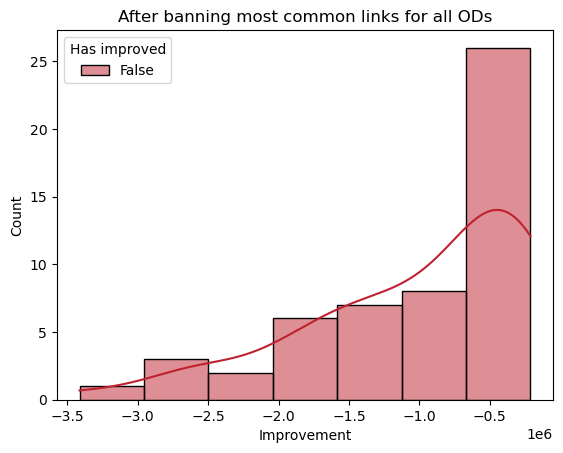

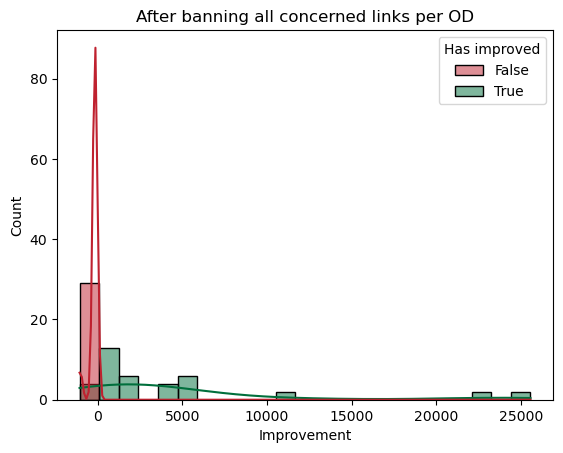

In [58]:
sns.histplot(data=df2, x="Improvement", hue="Has improved", palette="blend:#bf212f,#006f3c", kde=True)
plt.title("After banning most common links for all ODs")
plt.show()
sns.histplot(data=df, x="Improvement", hue="Has improved", palette="blend:#bf212f,#006f3c", kde=True)
plt.title("After banning all concerned links per OD")
plt.show()

## Threshold

In [19]:
for threshold in range(-4, 1):
    mask = (UE_OD_flows > 0) & (SO_OD_flows <10**threshold)
    mask.sum()
    
    print(f"Threshold : {10**threshold}, mask.sum : {mask.sum()}")

    try_removing_braess(net, mask, save_folder="files/masked/threshold_{threshold}", export_folder="exports/masked/threshold_{threshold}")

Threshold : 0.0001, mask.sum : 135


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [48:14<00:00, 82.71s/it]


Threshold : 0.001, mask.sum : 136


100%|██████████| 36/36 [52:22<00:00, 87.29s/it]


Threshold : 0.01, mask.sum : 137


100%|██████████| 37/37 [53:42<00:00, 87.11s/it]


Threshold : 0.1, mask.sum : 163


100%|██████████| 47/47 [1:08:37<00:00, 87.61s/it]


Threshold : 1, mask.sum : 252


100%|██████████| 65/65 [1:34:00<00:00, 86.77s/it]


In [28]:
len(UE_OD_flows[(UE_OD_flows<1) & (UE_OD_flows>0)])

5178

In [ ]:
mask.sum(axis=2)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  6,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  2,  2,  0,  0,  0,  0,  2,  0,
         7,  0,  6,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
         0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
         0,  0,  0,  0,  5,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  5,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 

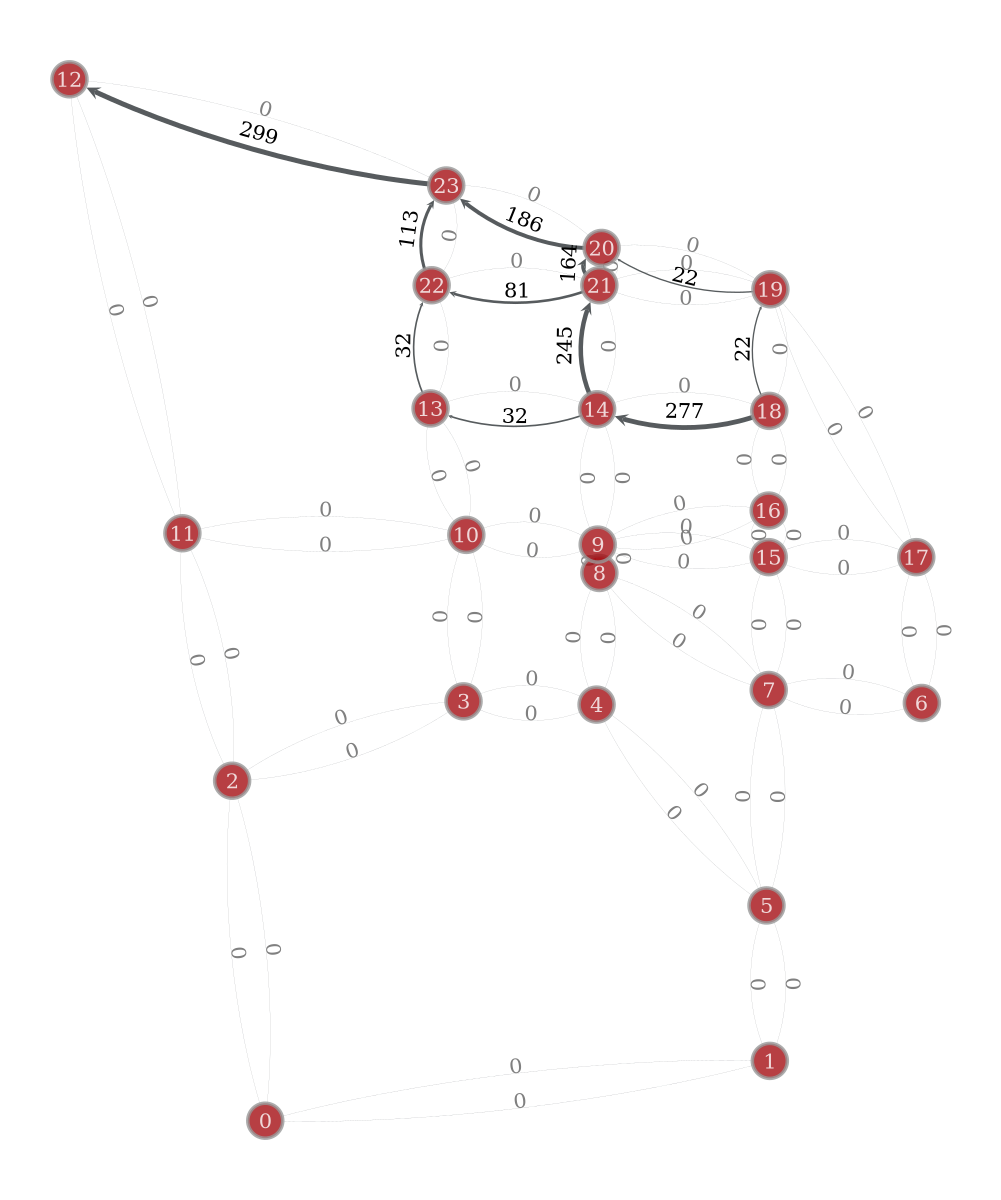

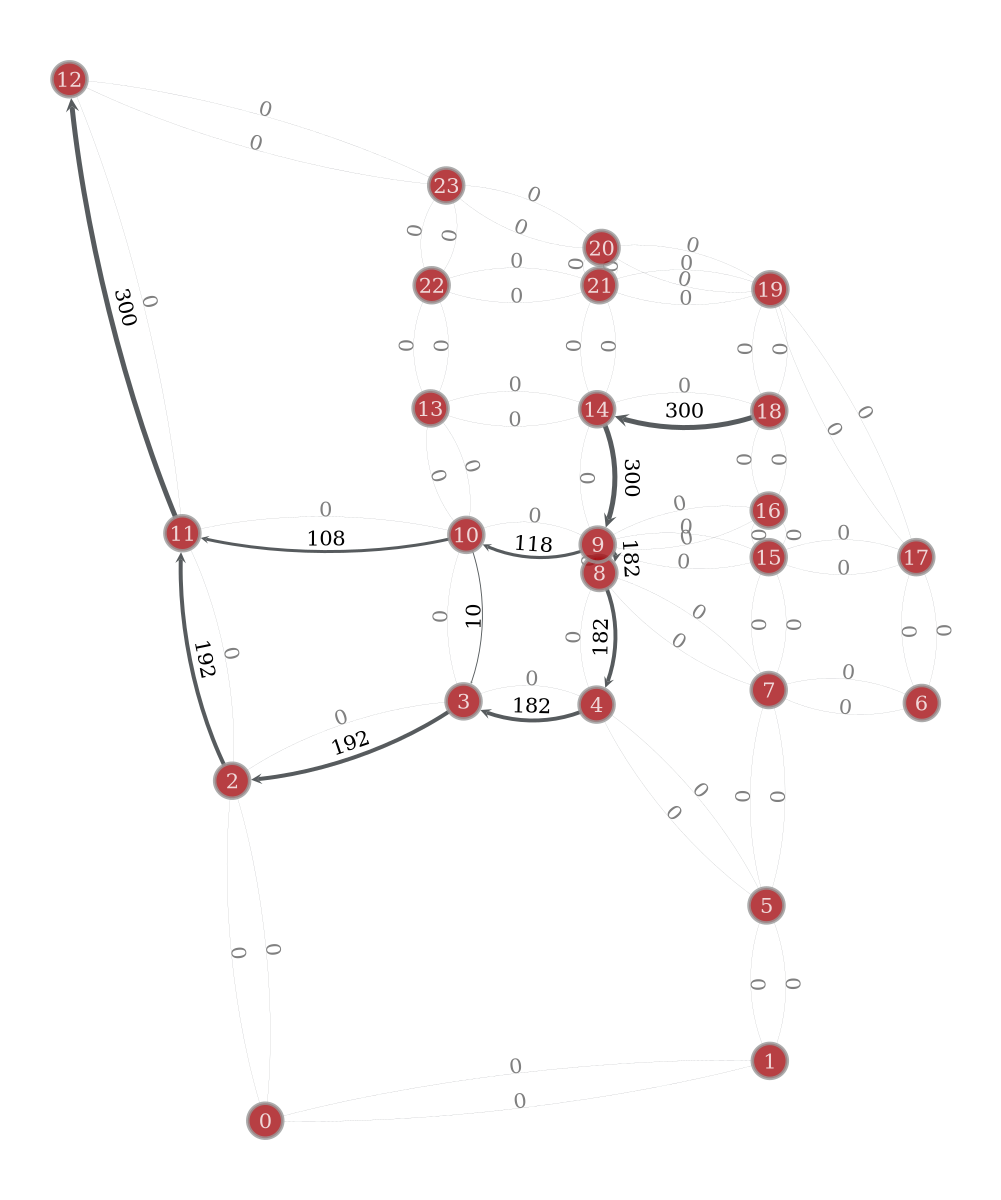

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8a9304b800, at 0x7f8a8aabac60>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8a9304b800, at 0x7f8a8b8db3e0>)

In [ ]:
net.draw(flows_by_OD=OD_flows, d=12, o=18), net.draw(flows_by_OD=OD_SO_flows, d=12, o=18)

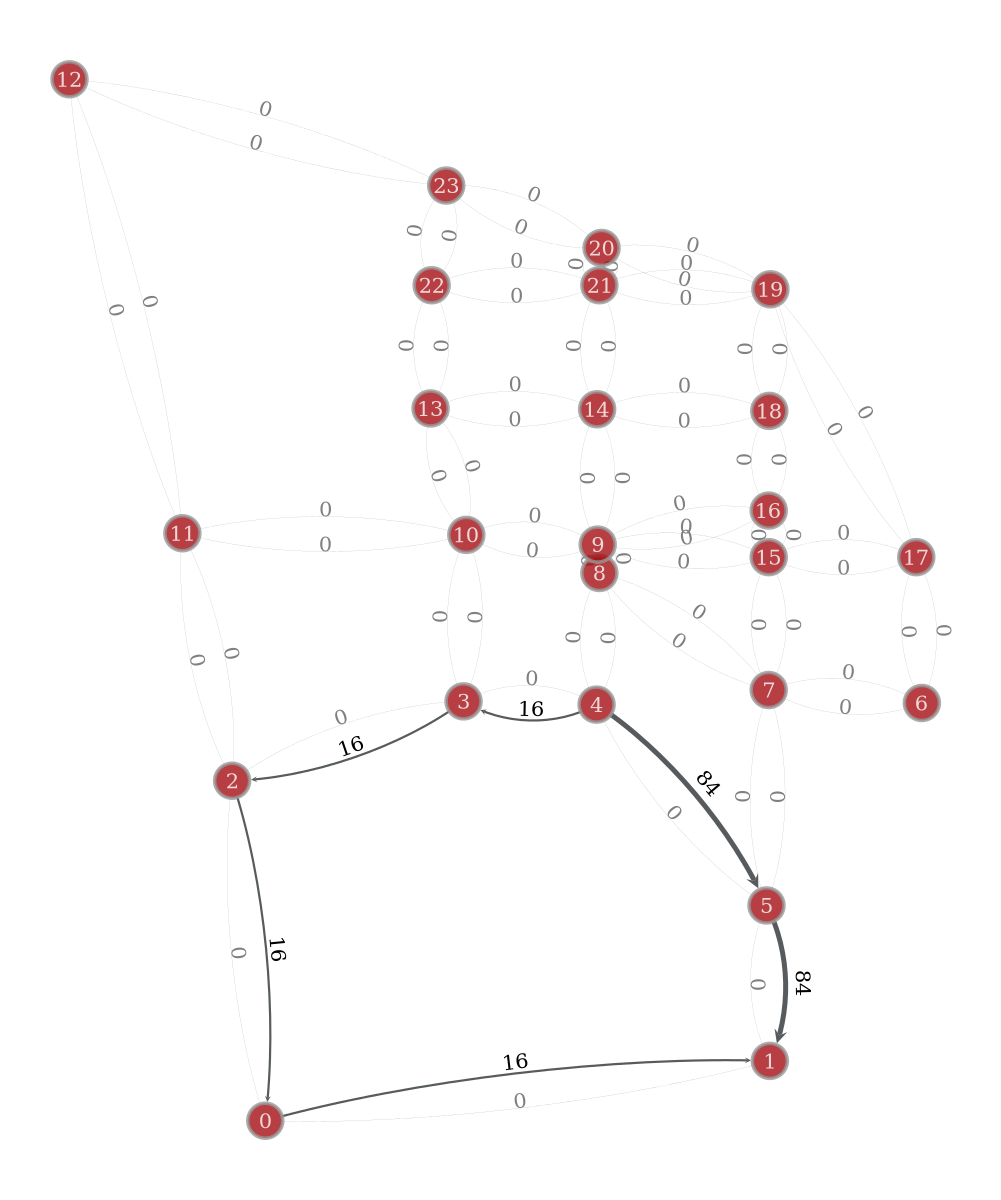

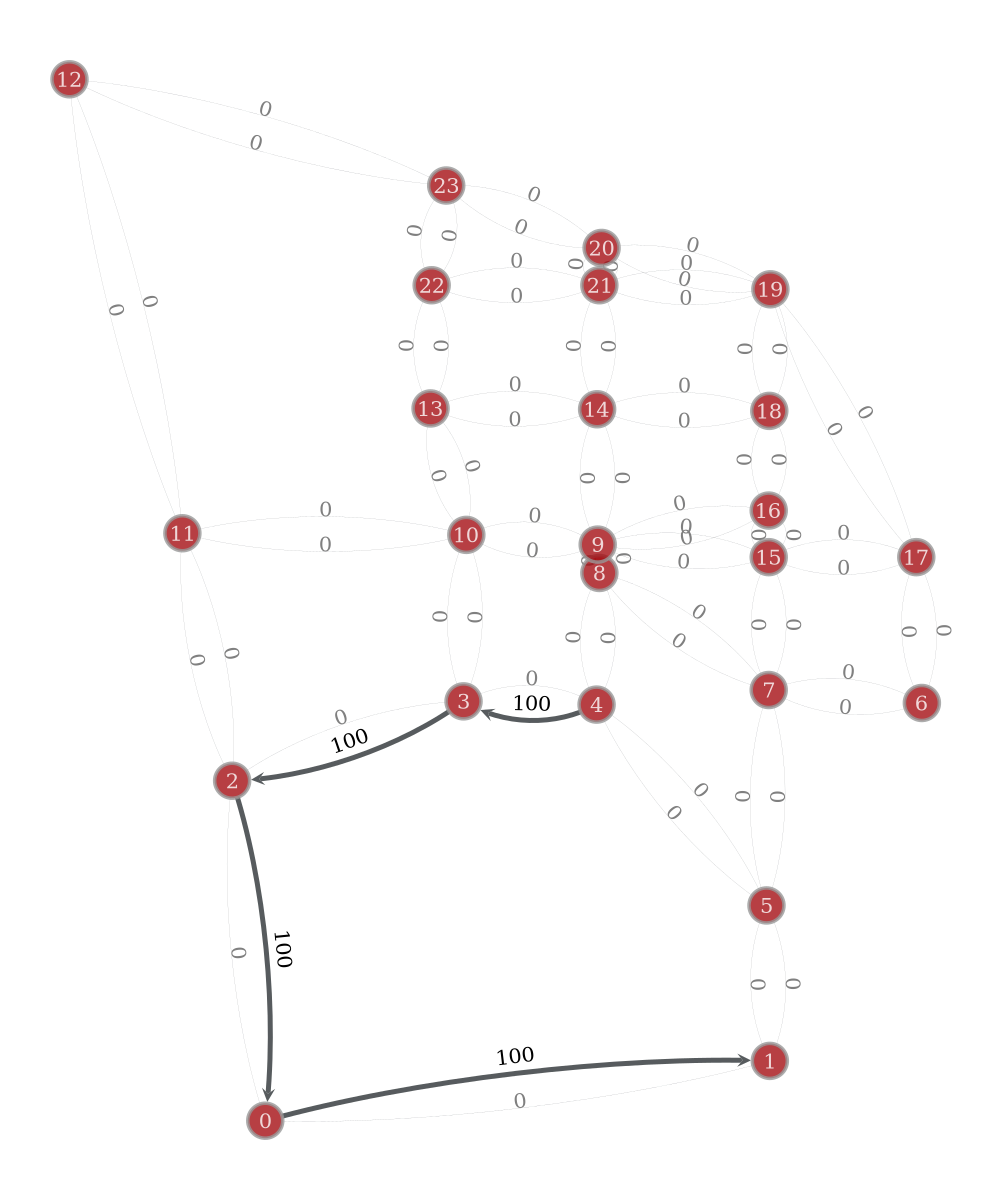

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8a9304b800, at 0x7f8a8b9ce6f0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8a9304b800, at 0x7f8a8b97fcb0>)

In [ ]:
net.draw(flows_by_OD=OD_flows, d=1, o=4), net.draw(flows_by_OD=OD_SO_flows, d=1, o=4)

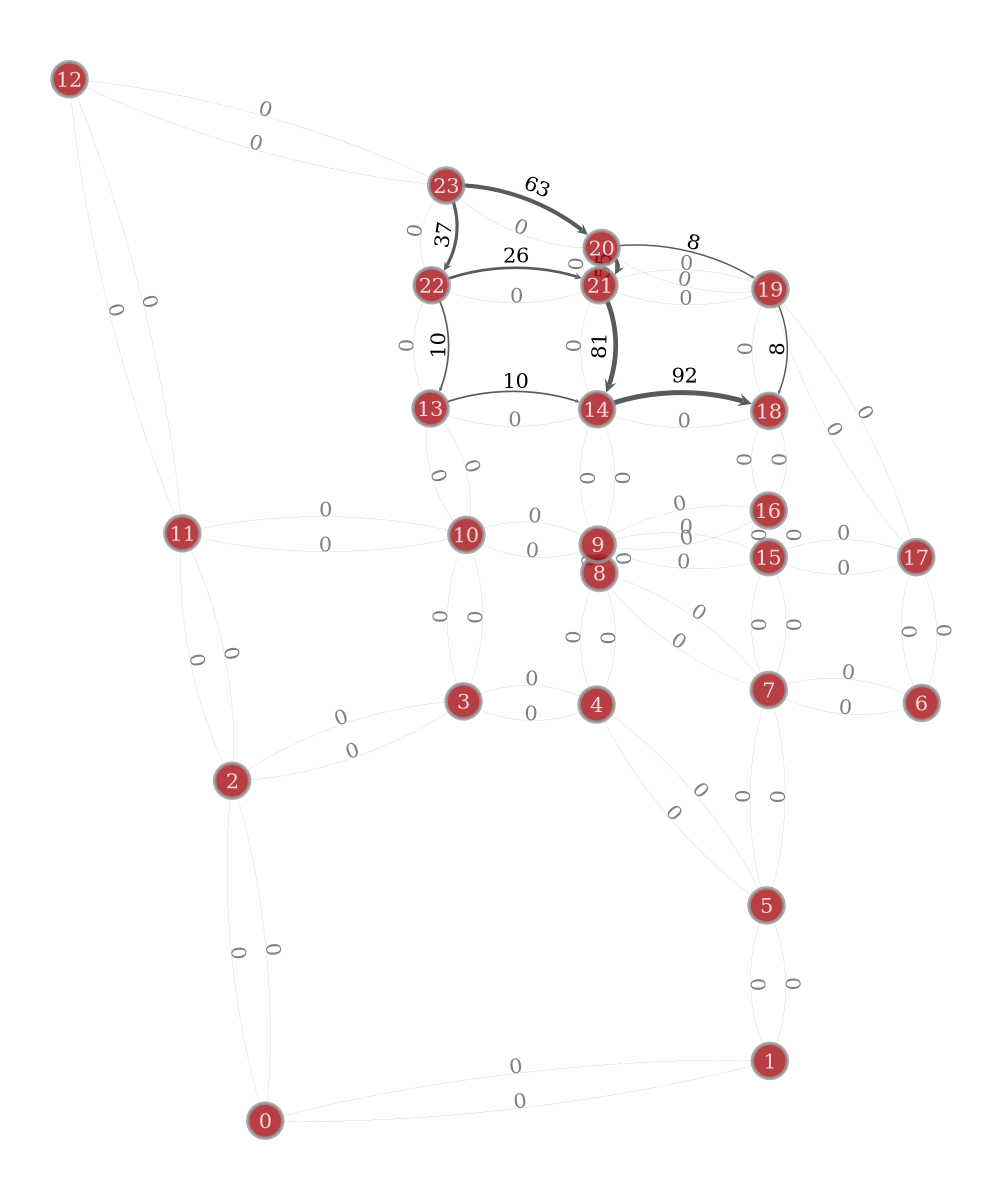

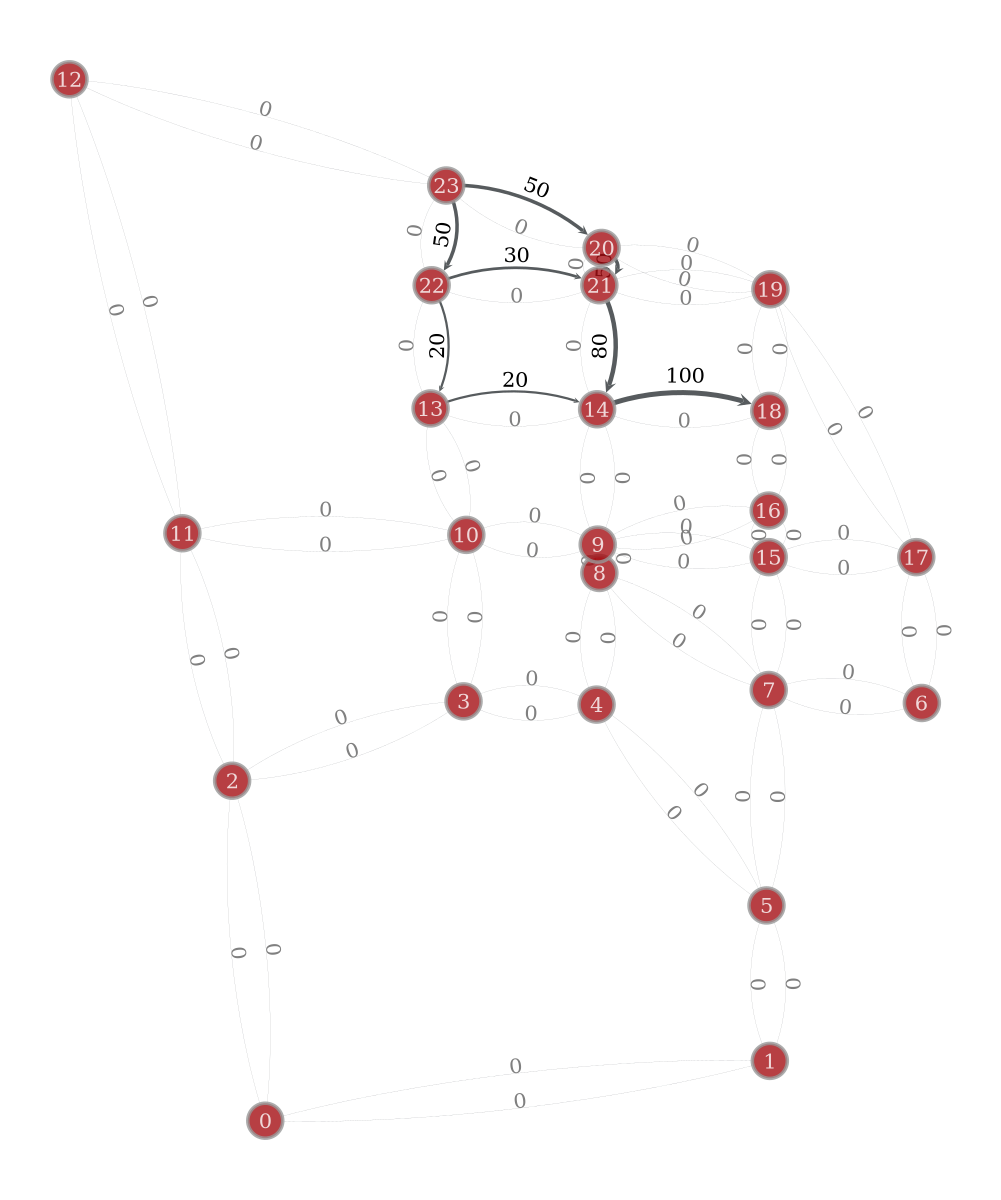

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8a9304b800, at 0x7f8a8aabb320>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8a9304b800, at 0x7f8a8b9cd850>)

In [ ]:
net.draw(flows_by_OD=OD_flows, d=18, o=23), net.draw(flows_by_OD=OD_SO_flows, d=18, o=23)

In [ ]:
mask[18,23]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [ ]:
# Remove Braess Links for a given OD pair
o, d = 18, 23
masked_by_origin, masked_flows = frankwolf(net, net.trips, OD_mask={(o,d) : ~mask[o,d]}, verbose=1, tolerance= 1e-4, n_max=2e5)
net.save_flow(masked_by_origin, f"o{o}d{d}", folder="files/masked")
net.save_flow(masked_flows, f"o{o}d{d}", folder="files/masked")
net.export_flow(masked_by_origin, f"o{o}d{d}", folder="exports/masked")
net.export_flow(masked_flows, f"o{o}d{d}", folder="exports/masked")

0it [00:00, ?it/s]

### Remove braess links

#### All braess links for one od

In [ ]:
# Remove potential Braess Links for all OD pairs
OD_flows = net.load_flow("OD_flows")
OD_SO_flows = net.load_flow("OD_SO_flows")
results = try_removing_braess(net, OD_flows, OD_SO_flows)
results

0it [00:00, ?it/s]

Removed links  N Removed Links  \
o  d                                                              
0  19                ([0, 3, 15, 17, 19, 55],)                6   
1  4                                ([3, 14],)                2   
   8                                ([3, 14],)                2   
   9                                ([3, 14],)                2   
   14                               ([3, 14],)                2   
...                                        ...              ...   
22 3                           ([30, 39, 70],)                3   
   4                           ([30, 39, 70],)                3   
   5                           ([30, 39, 70],)                3   
23 16  ([40, 44, 57, 60, 64, 66, 70, 71, 75],)                9   
   18                              ([60, 63],)                2   

       Total Travel Time  Improvement  
o  d                                   
0  19       7.480691e+06 -1181.135383  
1  4        7.479804e+06  -294.441258  
   8        7.479692e+06  -181.989779  
   9        7.474682e+06  4827.925601  
   14       7.479504e+06     6.237631  
...                  ...          ...  
22 3        7.474923e+06  4586.986012  
   4        7.478584e+06   925.888261  
   5        7.478752e+06   757.687344  
23 16       7.479785e+06  -274.541124  
   18       7.479588e+06   -77.602788  

[65 rows x 4 columns]

In [ ]:
results.Improvement.describe()

count       65.000000
mean      2623.821625
std       6012.966239
min      -1181.135383
25%       -268.097628
50%        -36.438661
75%       2152.688481
max      25431.056662
Name: Improvement, dtype: float64

Text(0, 0.5, 'Improvement in total travel time')

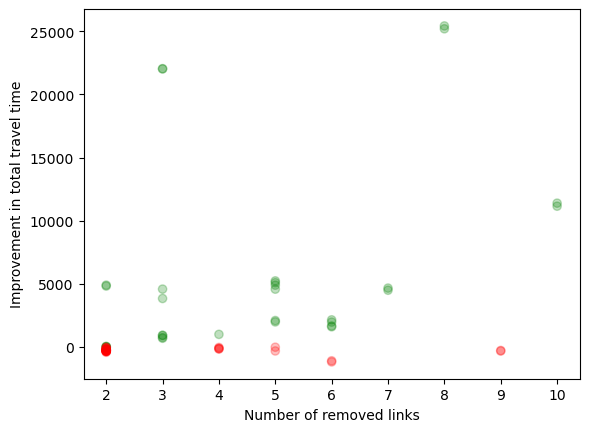

In [ ]:
plt.scatter(results["N Removed Links"], results["Improvement"], color = np.where(results["Improvement"]>0, "green", "red"), alpha=0.25)
plt.xlabel("Number of removed links")
plt.ylabel("Improvement in total travel time")

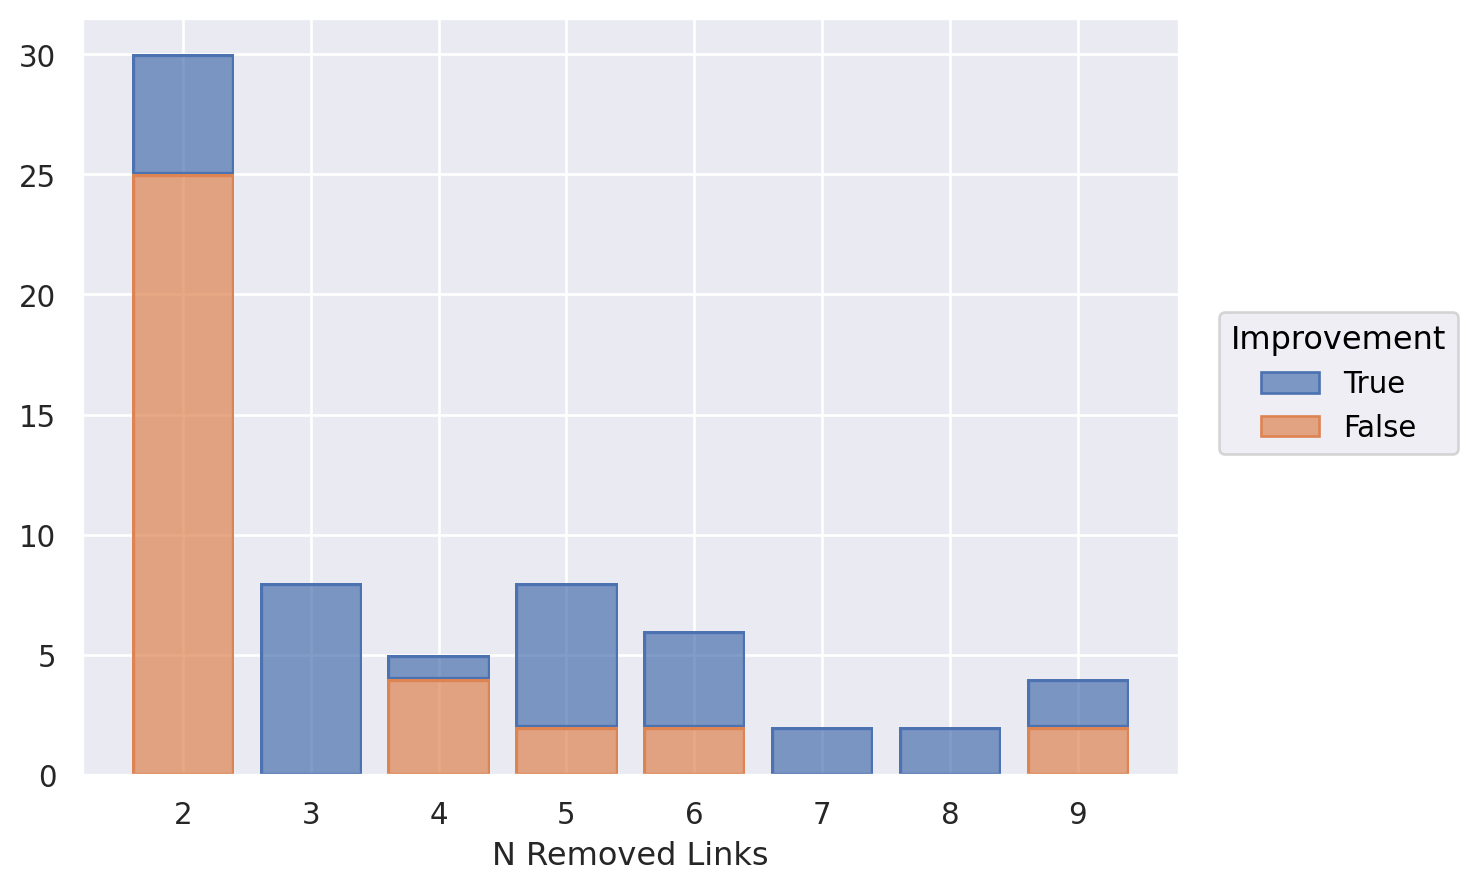

In [ ]:
(
    so.Plot(data=results, x="N Removed Links", color=(results.Improvement>0))
    .add(so.Bar(), so.Hist(), so.Stack(), so.Shift(x=-0.5))
    .label()
    .plot()
)

In [ ]:
results.sort_values("Improvement", ascending=False)

Removed links  N Removed Links  \
o  d                                                                  
12 14          ([38, 40, 64, 66, 70, 71, 74, 75],)                8   
14 12          ([41, 43, 45, 65, 68, 69, 72, 73],)                8   
13 12                              ([41, 72, 73],)                3   
12 13                              ([38, 70, 75],)                3   
   18  ([38, 40, 60, 63, 64, 66, 70, 71, 74, 75],)               10   
...                                            ...              ...   
16 19                                  ([52, 58],)                2   
3  15                                  ([24, 28],)                2   
18 11                                  ([39, 43],)                2   
19 0                    ([2, 13, 16, 18, 53, 59],)                6   
0  19                    ([0, 3, 15, 17, 19, 55],)                6   

       Total Travel Time   Improvement  
o  d                                    
12 14       7.454079e+06  25431.056662  
14 12       7.454306e+06  25203.901283  
13 12       7.457464e+06  22046.200718  
12 13       7.457486e+06  22024.508772  
   18       7.468115e+06  11394.541178  
...                  ...           ...  
16 19       7.479846e+06   -335.499112  
3  15       7.479882e+06   -371.969391  
18 11       7.479925e+06   -414.728589  
19 0        7.480601e+06  -1090.624021  
0  19       7.480691e+06  -1181.135383  

[65 rows x 4 columns]

#### 1 link at a time

In [ ]:
# Remove potential Braess Links for all OD pairs
OD_flows = net.load_flow("OD_flows")
OD_SO_flows = net.load_flow("OD_SO_flows")
results2 = try_removing_braess_1_OD(net, OD_flows, OD_SO_flows)
results2

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0 19 0 6 7482319.498062023 -2809.4582311129197
0 19 3 6 7482319.498062023 -2809.4582311129197
0 19 15 6 7482209.5701529775 -2699.5303220674396
0 19 17 6 7482871.0868401155 -3361.0470092054456
0 19 19 6 7482871.0868401155 -3361.0470092054456
0 19 55 6 7480691.175213638 -1181.1353827277198


  0%|          | 0/2 [00:00<?, ?it/s]

1 4 3 2 7479804.481088652 -294.4412577422336
1 4 14 2 7479804.481088652 -294.4412577422336


  0%|          | 0/2 [00:00<?, ?it/s]

1 8 3 2 7479692.0296095405 -181.98977863043547
1 8 14 2 7479665.520519511 -155.48068860080093


  0%|          | 0/2 [00:00<?, ?it/s]

1 9 3 2 7474682.114229691 4827.925601218827
1 9 14 2 7474644.404850569 4865.63498034142


  0%|          | 0/2 [00:00<?, ?it/s]

1 14 3 2 7479503.802199787 6.237631122581661
1 14 14 2 7479636.46094196 -126.42111105006188


  0%|          | 0/7 [00:00<?, ?it/s]

1 16 3 7 7475083.667400048 4426.372430861928
1 16 15 7 7475025.713998611 4484.325832298957
1 16 17 7 7479794.878959648 -284.8391287382692
1 16 19 7 7479794.878959648 -284.8391287382692
1 16 21 7 7479762.7375185955 -252.69768768548965
1 16 48 7 7475042.934513572 4467.10531733837
1 16 54 7 7479794.878959648 -284.8391287382692


  0%|          | 0/6 [00:00<?, ?it/s]

1 18 3 6 7477423.801250374 2086.2385805360973
1 18 15 6 7477483.655532998 2026.384297912009
1 18 17 6 7480888.643300955 -1378.6034700451419
1 18 19 6 7480888.643300955 -1378.6034700451419
1 18 55 6 7480896.549034926 -1386.509204016067
1 18 60 6 7480896.549034926 -1386.509204016067


  0%|          | 0/6 [00:00<?, ?it/s]

1 21 3 6 7477908.362086533 1601.6777443774045
1 21 15 6 7477838.790809434 1671.2490214761347
1 21 17 6 7480630.967786843 -1120.9279559329152
1 21 19 6 7480630.967786843 -1120.9279559329152
1 21 55 6 7477963.737111478 1546.3027194319293
1 21 62 6 7480969.500842224 -1459.4610113138333


  0%|          | 0/2 [00:00<?, ?it/s]

2 15 24 2 7479954.466382942 -444.4265520321205
2 15 28 2 7479833.23697797 -323.19714706018567


  0%|          | 0/2 [00:00<?, ?it/s]

3 15 24 2 7479814.186475622 -304.14664471149445
3 15 28 2 7479882.009221677 -371.96939076669514


  0%|          | 0/3 [00:00<?, ?it/s]

3 22 9 3 7475591.00013404 3919.0396968703717
3 22 33 3 7475667.174178707 3842.8656522026286
3 22 41 3 7475667.174178707 3842.8656522026286


  0%|          | 0/2 [00:00<?, ?it/s]

4 1 11 2 7479753.929753465 -243.8899225546047
4 1 13 2 7479753.929753465 -243.8899225546047


  0%|          | 0/2 [00:00<?, ?it/s]

4 15 24 2 7479465.922815078 44.11701583210379
4 15 28 2 7479465.922815078 44.11701583210379


  0%|          | 0/5 [00:00<?, ?it/s]

4 20 12 5 7477409.158806308 2100.8810246018693
4 20 24 5 7477443.441211433 2066.598619476892
4 20 27 5 7477292.15172408 2217.888106830418
4 20 45 5 7477449.496129356 2060.5437015537173
4 20 68 5 7477449.496129356 2060.5437015537173


  0%|          | 0/3 [00:00<?, ?it/s]

4 22 9 3 7478817.100063455 692.9397674547508
4 22 33 3 7478817.100063455 692.9397674547508
4 22 41 3 7478817.100063455 692.9397674547508


  0%|          | 0/5 [00:00<?, ?it/s]

5 18 15 5 7474272.573110205 5237.466720704921
5 18 17 5 7481895.4326798 -2385.3928488902748
5 18 19 5 7481895.4326798 -2385.3928488902748
5 18 55 5 7481725.074721878 -2215.0348909683526
5 18 60 5 7481725.074721878 -2215.0348909683526


  0%|          | 0/3 [00:00<?, ?it/s]

5 22 9 3 7478594.419588614 915.6202422957867
5 22 33 3 7478594.419588614 915.6202422957867
5 22 41 3 7478594.419588614 915.6202422957867


  0%|          | 0/5 [00:00<?, ?it/s]

6 12 17 5 7474928.675784205 4581.364046704955
6 12 55 5 7474928.675784205 4581.364046704955
6 12 61 5 7474871.822733977 4638.217096933164
6 12 65 5 7474950.373236427 4559.666594482958
6 12 73 5 7474928.675784205 4581.364046704955


  0%|          | 0/2 [00:00<?, ?it/s]

8 1 11 2 7479892.623123265 -382.5832923548296
8 1 13 2 7479830.570442339 -320.5306114293635


  0%|          | 0/2 [00:00<?, ?it/s]

9 1 11 2 7474777.939333653 4732.100497256964
9 1 13 2 7474608.952409544 4901.087421366014


  0%|          | 0/2 [00:00<?, ?it/s]

10 14 33 2 7479532.296805806 -22.256974896416068
10 14 40 2 7479532.296805806 -22.256974896416068


  0%|          | 0/2 [00:00<?, ?it/s]

10 18 33 2 7479736.348373002 -226.30854209233075
10 18 40 2 7479736.348373002 -226.30854209233075


  0%|          | 0/2 [00:00<?, ?it/s]

10 19 33 2 7479812.679866944 -302.6400360343978
10 19 40 2 7479803.952388145 -293.9125572349876


  0%|          | 0/4 [00:00<?, ?it/s]

10 20 33 4 7478436.747819131 1073.2920117788017
10 20 41 4 7478643.329246108 866.7105848016217
10 20 72 4 7478739.046884279 770.9929466312751
10 20 74 4 7478843.696271997 666.3435589130968


  0%|          | 0/4 [00:00<?, ?it/s]

10 21 33 4 7479635.485136 -125.4453050903976
10 21 40 4 7479659.372905785 -149.33307487517595
10 21 41 4 7479588.288588375 -78.2487574648112
10 21 71 4 7479588.288588375 -78.2487574648112


  0%|          | 0/2 [00:00<?, ?it/s]

11 14 33 2 7479514.517900374 -4.47806946374476
11 14 40 2 7479479.298840512 30.740990398451686


  0%|          | 0/4 [00:00<?, ?it/s]

11 15 24 4 7480083.6177126765 -573.5778817664832
11 15 28 4 7479563.205959935 -53.16612902469933
11 15 31 4 7479824.32065976 -314.2808288503438
11 15 35 4 7479824.32065976 -314.2808288503438


  0%|          | 0/2 [00:00<?, ?it/s]

11 18 33 2 7479542.138354572 -32.098523661494255
11 18 40 2 7479766.408623868 -256.3687929576263


  0%|          | 0/5 [00:00<?, ?it/s]

12 6 38 5 7474612.610210137 4897.4296207726
12 6 53 5 7474612.610210137 4897.4296207726
12 6 59 5 7474612.610210137 4897.4296207726
12 6 63 5 7474652.754262089 4857.285568821244
12 6 74 5 7474418.32616617 5091.713664740324


  0%|          | 0/3 [00:00<?, ?it/s]

12 13 38 3 7457485.5310591925 22024.50877171755
12 13 70 3 7457485.5310591925 22024.50877171755
12 13 75 3 7457485.5310591925 22024.50877171755


  0%|          | 0/8 [00:00<?, ?it/s]

12 14 38 8 7454236.577519198 25273.462311712094
12 14 40 8 7479972.298456883 -462.258625973016
12 14 64 8 7479589.199501359 -79.15967044886202
12 14 66 8 7479048.507797331 461.532033579424
12 14 70 8 7479769.637910662 -259.598079752177
12 14 71 8 7479723.700365199 -213.6605342887342
12 14 74 8 7479589.199501359 -79.15967044886202
12 14 75 8 7479618.842500233 -108.80266932304949


  0%|          | 0/10 [00:00<?, ?it/s]

12 18 38 10 7468108.437782313 11401.602048597299
12 18 40 10 7479608.616214604 -98.57638369407505
12 18 60 10 7479806.870209869 -296.8303789589554
12 18 63 10 7479806.870209869 -296.8303789589554
12 18 64 10 7479729.894606623 -219.85477571282536
12 18 66 10 7479371.913949012 138.1258818982169
12 18 70 10 7479765.831438813 -255.79160790331662
12 18 71 10 7479711.573304144 -201.53347323369235
12 18 74 10 7479797.327747275 -287.2879163650796
12 18 75 10 7479807.314843455 -297.2750125452876


  0%|          | 0/3 [00:00<?, ?it/s]

13 12 41 3 7457463.839112971 22046.200717939064
13 12 72 3 7457463.839112971 22046.200717939064
13 12 73 3 7457463.839112971 22046.200717939064


  0%|          | 0/2 [00:00<?, ?it/s]

14 1 11 2 7479532.893084898 -22.85325398761779
14 1 13 2 7479790.399370999 -280.35954008903354


  0%|          | 0/2 [00:00<?, ?it/s]

14 10 39 2 7479777.252665741 -267.2128348313272
14 10 43 2 7479777.252665741 -267.2128348313272


  0%|          | 0/2 [00:00<?, ?it/s]

14 11 39 2 7479594.76657231 -84.726741399616
14 11 43 2 7479594.76657231 -84.726741399616


  0%|          | 0/8 [00:00<?, ?it/s]

14 12 41 8 7479643.1497544 -133.10992349032313
14 12 43 8 7479801.011333769 -290.9715028591454
14 12 45 8 7479221.900314272 288.13951663766056
14 12 65 8 7479623.400109062 -113.36027815192938
14 12 68 8 7479623.400109062 -113.36027815192938
14 12 69 8 7479661.519070359 -151.479239448905
14 12 72 8 7479685.880578561 -175.84074765071273
14 12 73 8 7454191.462451688 25318.577379222028


  0%|          | 0/2 [00:00<?, ?it/s]

15 2 25 2 7479786.475434998 -276.4356040880084
15 2 47 2 7479786.475434998 -276.4356040880084


  0%|          | 0/2 [00:00<?, ?it/s]

15 3 25 2 7479770.622790435 -260.58295952528715
15 3 47 2 7479770.622790435 -260.58295952528715


  0%|          | 0/2 [00:00<?, ?it/s]

15 4 25 2 7479700.334458031 -190.29462712071836
15 4 47 2 7479700.334458031 -190.29462712071836


  0%|          | 0/4 [00:00<?, ?it/s]

15 11 25 4 7479801.853744204 -291.8139132941142
15 11 26 4 7479820.136703466 -310.0968725560233
15 11 32 4 7479625.176102311 -115.13627140130848
15 11 47 4 7479648.744598955 -138.70476804487407


  0%|          | 0/7 [00:00<?, ?it/s]

16 1 13 7 7474757.4719722485 4752.567858661525
16 1 16 7 7479480.009190209 30.03064070083201
16 1 18 7 7474825.405364543 4684.634466366842
16 1 46 7 7479824.24068365 -314.2008527396247
16 1 49 7 7479480.009190209 30.03064070083201
16 1 51 7 7474905.399575115 4604.64025579486
16 1 53 7 7479480.009190209 30.03064070083201


  0%|          | 0/2 [00:00<?, ?it/s]

16 19 52 2 7479712.964575773 -202.9247448630631
16 19 58 2 7479845.538943231 -335.4991123210639


  0%|          | 0/5 [00:00<?, ?it/s]

16 20 45 5 7479542.789467629 -32.74963671900332
16 20 52 5 7479519.454098449 -9.414267539046705
16 20 56 5 7479428.473714473 81.56611643731594
16 20 58 5 7479672.845983885 -162.8061529751867
16 20 68 5 7479542.789467629 -32.74963671900332


  0%|          | 0/9 [00:00<?, ?it/s]

16 23 41 9 7479943.4505814165 -433.41075050644577
16 23 43 9 7479943.4505814165 -433.41075050644577
16 23 45 9 7479722.670473071 -212.63064216077328
16 23 52 9 7479771.392828885 -261.3529979744926
16 23 56 9 7479872.313614302 -362.2737833922729
16 23 58 9 7479804.359908213 -294.3200773028657
16 23 68 9 7479783.283637454 -273.24380654376
16 23 69 9 7479689.8772557825 -179.83742487244308
16 23 72 9 7479622.711072697 -112.67124178726226


  0%|          | 0/6 [00:00<?, ?it/s]

18 1 13 6 7477478.057423688 2031.982407222502
18 1 16 6 7480792.7996212 -1282.759790290147
18 1 18 6 7477353.784286783 2156.255544126965
18 1 53 6 7480792.7996212 -1282.759790290147
18 1 58 6 7480745.036609773 -1234.9967788625509
18 1 59 6 7480806.000176771 -1295.9603458605707


  0%|          | 0/5 [00:00<?, ?it/s]

18 5 16 5 7481981.43535333 -2471.3955224202946
18 5 18 5 7474416.415448616 5093.624382293783
18 5 53 5 7481981.43535333 -2471.3955224202946
18 5 58 5 7482241.611570814 -2731.571739903651
18 5 59 5 7481841.277062047 -2331.237231137231


  0%|          | 0/2 [00:00<?, ?it/s]

18 10 39 2 7479828.746448871 -318.70661796070635
18 10 43 2 7479828.746448871 -318.70661796070635


  0%|          | 0/2 [00:00<?, ?it/s]

18 11 39 2 7479924.768419415 -414.72858850471675
18 11 43 2 7479924.768419415 -414.72858850471675


  0%|          | 0/10 [00:00<?, ?it/s]

18 12 41 10 7479502.65169201 7.388138899579644
18 12 43 10 7479847.075853616 -337.0360227059573
18 12 45 10 7479676.156234007 -166.11640309728682
18 12 58 10 7479570.921012785 -60.88118187524378
18 12 61 10 7479570.921012785 -60.88118187524378
18 12 65 10 7479707.213017773 -197.17318686284125
18 12 68 10 7479669.797627628 -159.75779671780765
18 12 69 10 7479725.866256995 -215.82642608508468
18 12 72 10 7479966.195048602 -456.155217692256
18 12 73 10 7468075.655202234 11434.384628675878


  0%|          | 0/2 [00:00<?, ?it/s]

18 20 58 2 7479602.913043676 -92.87321276590228
18 20 61 2 7479682.937468701 -172.8976377910003


  0%|          | 0/2 [00:00<?, ?it/s]

18 23 58 2 7479555.3892203355 -45.349389425478876
18 23 61 2 7479550.814620437 -40.7747895270586


  0%|          | 0/6 [00:00<?, ?it/s]

19 0 2 6 7482156.9784872215 -2646.938656311482
19 0 13 6 7482156.9784872215 -2646.938656311482
19 0 16 6 7482876.746939839 -3366.707108928822
19 0 18 6 7482301.504847078 -2791.465016167611
19 0 53 6 7482876.746939839 -3366.707108928822
19 0 59 6 7480600.663852253 -1090.6240213429555


  0%|          | 0/2 [00:00<?, ?it/s]

19 10 39 2 7479715.819723756 -205.77989284601063
19 10 43 2 7479715.85604103 -205.81621011998504


  0%|          | 0/2 [00:00<?, ?it/s]

19 16 57 2 7479942.929064795 -432.88923388533294
19 16 60 2 7479825.216389581 -315.17655867058784


  0%|          | 0/5 [00:00<?, ?it/s]

20 4 22 5 7477577.6409494765 1932.3988814335316
20 4 25 5 7477289.471910974 2220.567919936031
20 4 42 5 7477289.471910974 2220.567919936031
20 4 64 5 7477320.198169723 2189.841661186889
20 4 66 5 7477468.229631052 2041.8101998576894


  0%|          | 0/5 [00:00<?, ?it/s]

20 16 44 5 7479710.477582728 -200.43775181751698
20 16 57 5 7479736.43684476 -226.3970138495788
20 16 60 5 7479636.657639221 -126.61780831124634
20 16 64 5 7479707.414958435 -197.37512752506882
20 16 66 5 7479707.414958435 -197.37512752506882


  0%|          | 0/2 [00:00<?, ?it/s]

20 18 60 2 7479544.207055362 -34.16722445189953
20 18 63 2 7479650.485649201 -140.44581829104573


  0%|          | 0/6 [00:00<?, ?it/s]

21 1 13 6 7477844.178320137 1665.8615107731894
21 1 16 6 7480858.787921985 -1348.748091074638
21 1 18 6 7477844.178320137 1665.8615107731894
21 1 53 6 7480858.787921985 -1348.748091074638
21 1 59 6 7477915.920902778 1594.1189281316474
21 1 67 6 7480901.856057053 -1391.81622614339


  0%|          | 0/4 [00:00<?, ?it/s]

21 10 39 4 7479625.844753094 -115.80492218397558
21 10 43 4 7479715.255445439 -205.21561452932656
21 10 69 4 7479666.918869068 -156.87903815787286
21 10 70 4 7479666.918869068 -156.87903815787286


  0%|          | 0/3 [00:00<?, ?it/s]

22 3 30 3 7474923.053818788 4586.9860121216625
22 3 39 3 7474923.053818788 4586.9860121216625
22 3 70 3 7474923.053818788 4586.9860121216625


  0%|          | 0/3 [00:00<?, ?it/s]

22 4 30 3 7478544.72156959 965.3182613197714
22 4 39 3 7478584.151569875 925.8882610350847
22 4 70 3 7478584.151569875 925.8882610350847


  0%|          | 0/3 [00:00<?, ?it/s]

22 5 30 3 7478521.672629858 988.3672010516748
22 5 39 3 7478752.352487301 757.687343608588
22 5 70 3 7478752.352487301 757.687343608588


  0%|          | 0/9 [00:00<?, ?it/s]

23 16 40 9 7479749.625876611 -239.58604570105672
23 16 44 9 7479933.629984796 -423.5901538860053
23 16 57 9 7479656.183488091 -146.14365718141198
23 16 60 9 7479627.75939247 -117.71956156007946
23 16 64 9 7479714.608034856 -204.5682039456442
23 16 66 9 7479921.6860001255 -411.64616921544075
23 16 70 9 7479749.625876611 -239.58604570105672
23 16 71 9 7479932.907700799 -422.86786988936365
23 16 75 9 7479757.1750541795 -247.13522326946259


  0%|          | 0/2 [00:00<?, ?it/s]

23 18 60 2 7479587.642619138 -77.60278822761029
23 18 63 2 7479558.00369126 -47.96386034972966


AttributeError: 'list' object has no attribute 'set_index'